Data and script for Wagner et al. 2021 (https://doi.org/10.5194/os-17-1473-2021) <br>
Figures contributed by Patrick Wagner (pwagner@geomar.de)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.patches as patches
import pandas as pd
import datetime as dt
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from scipy import signal
from functools import partial
from matplotlib.colors import ListedColormap
from IPython.display import Image

plt.rcParams["grid.linewidth"] = 0.2
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["xtick.major.width"] = 0.2
plt.rcParams["xtick.major.pad"] = 0.5
plt.rcParams["xtick.major.size"] = 1.5
plt.rcParams["ytick.major.width"] = 0.2
plt.rcParams["ytick.major.pad"] = 0.5
plt.rcParams["ytick.major.size"] = 1.5
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

fs=7
plt.rc('font', size=fs) #controls default text size
plt.rc('axes', titlesize=fs) #fontsize of the title
plt.rc('axes', labelsize=fs) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fs) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fs) #fontsize of the y tick labels
plt.rc('legend', fontsize=fs) #fontsize of the legend

In [2]:

import xorca_lonlat2ij as xll2ij
def make_lon_monotonous(lon):
    lon += (lon < lon[:,0]) * 360
    return lon


scratch = "/gxfs_work1/geomar/smomw233/SCRATCH/"

meshdir = scratch + "MESHMASK/"
meshhgr_025 = "ORCA025/mesh_hgr.nc"
meshzgr_025 = "ORCA025/mesh_zgr.nc"
maskfile_025 = "ORCA025/mask.nc"
meshmask_n20 = "NUSA20/1_mesh_mask_rev9753.nc"
meshmask_n20_host = "NUSA20/mesh_mask_rev9753.nc"



datahgr_025 = xr.open_dataset(meshdir+meshhgr_025)
datazgr_025 = xr.open_dataset(meshdir+meshzgr_025)
datamask_025 = xr.open_dataset(meshdir+maskfile_025)\
        .assign_coords(nav_lon=datahgr_025.nav_lon,nav_lat=datahgr_025.nav_lat)

datameshmask_n20 = xr.open_dataset(meshdir+meshmask_n20)
datameshmask_n20 = datameshmask_n20.assign_coords(nav_lon=datameshmask_n20.nav_lon,nav_lat=datameshmask_n20.nav_lat)
datameshmask_n20_host = xr.open_dataset(meshdir+meshmask_n20_host)
datameshmask_n20_host = datameshmask_n20_host.assign_coords(nav_lon=datameshmask_n20_host.nav_lon,nav_lat=datameshmask_n20_host.nav_lat)


datamask_025['nav_lon']=make_lon_monotonous(datamask_025['nav_lon'])
datameshmask_n20_host['nav_lon']=make_lon_monotonous(datameshmask_n20_host['nav_lon'])





In [3]:
    
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
def format_tax(ax,y1,y2,tstart,freq='5AS',deltat=5):
    ax.set_xticks(pd.date_range(str(tstart)+'-01-01',str(y2+deltat)+'-01-01',freq=freq))
    ax.set_xticklabels(range(tstart,y2+deltat,deltat))
    ax.set_xlim(dt.date(y1,1,1),dt.date(y2,12,31))

    
def format_geo_axes(ax,draw_labels,top,bottom,left,right,linewidth=1,fs=7,color='white',alpha=0.5,linestyle='--',xloc=np.arange(-180,200,90),yloc=np.arange(-90,100,45)):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=draw_labels,linewidth=linewidth, color=color, alpha=alpha, linestyle=linestyle)
    gl.top_labels=top
    gl.bottom_labels=bottom
    gl.left_labels=left
    gl.right_labels=right
    gl.xlocator = mticker.FixedLocator(xloc)
    gl.ylocator = mticker.FixedLocator(yloc)
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {'size': fs, 'color': 'k'}
    gl.ylabel_style = {'size': fs, 'color': 'k'}
    
def butterworth_lowpass_filter(data, order=6, cutoff_freq=1.0/10.0, axis='time_counter'):
    """Filter input data.
    
    For unfiltered data, use `cutoff_freq=1`.
    
    Currently, this returns a numpy array.
    """
    a = data.dims.index(axis)
    fs = 1
    wn = cutoff_freq / (0.5*fs)
    B, A = signal.butter(order, wn, output="ba")
    return xr.apply_ufunc(partial(signal.filtfilt,B,A),data,a, dask='parallelized',output_dtypes=["float32"])

def butterworth_bandpass_filter(data, order=6, cutoff_freq1=1.0/10.0,cutoff_freq2=1.0/5.0, axis='time_counter'):
    """Filter input data.
    
    For unfiltered data, use `cutoff_freq=1`.
    
    Currently, this returns a numpy array.
    """
    a = data.dims.index(axis)
    fs = 1
    wn1 = cutoff_freq1 / (0.5*fs)
    B1, A1 = signal.butter(order, wn1, output="ba")
    lp1 = xr.apply_ufunc(partial(signal.filtfilt,B1,A1),data,a, dask='parallelized',output_dtypes=["float32"])
    wn2 = cutoff_freq2 / (0.5*fs)
    B2, A2 = signal.butter(order, wn2, output="ba")
    lp2 = xr.apply_ufunc(partial(signal.filtfilt,B2,A2),data,a, dask='parallelized',output_dtypes=["float32"])
    return lp2 - lp1

In [4]:
col_ref025='C0'
col_ref005='chartreuse'
col_obs='k'
col_wind='C3'
col_buoy='C1'
col_clim='C6'
lsmap = ListedColormap(['#4B4B4B'])

In [5]:
def figure02():
    ## Read SD
    obs_std = xr.open_dataset("FIGURE02/dt_global_allsat_phy_l4_adt_standard_deviation.nc").adt_std
    ref025_std = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(416,605),x=slice(48,309))
    ref005_std = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(740,1673),x=slice(313,1514))
    # Read time series
    obs_ts = xr.open_dataset("FIGURE02/dt_global_allsat_phy_l4_1993_2016_adt_archipel.nc").adt
    ref025_ts = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_1m_19580101_20161231_grid_T_sossheig_archipel.nc").sossheig
    ref005_ts = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_5d_19580101_20181231_grid_T_sossheig_archipel.nc").sossheig
    # Read auxillary variables
    ref025_lsmask = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(416,605),x=slice(48,309))
    ref005_lsmask = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(740,1673),x=slice(313,1514))
    ref005_archipelmask = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_archipel_mask.nc").archipel_mask.isel(y=slice(740,1673),x=slice(313,1514))
    ref025_bathy = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_mbathy.nc").mbathy.isel(y=slice(416,605),x=slice(48,309))


    ## Set up figure
    fig = plt.figure(figsize=cm2inch(16.5,11))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.27, hspace=None)
    ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
    ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
    ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
    ax4 = plt.subplot(2, 2, 4)
    ax = [ax1,ax2,ax3,ax4]

    ## Plot data
    #SD
    pc=(obs_std*100)\
       .plot.contourf(ax=ax[0],add_colorbar=False,levels=np.arange(0,10,0.5),transform=ccrs.PlateCarree())
    (ref025_std.isel(x=slice(0,-2),y=slice(0,-2))*100)\
       .plot.contourf(ax=ax[1],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,10,0.5),transform=ccrs.PlateCarree())
    (ref005_std*100)\
       .plot.contourf(ax=ax[2],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,10,0.5),transform=ccrs.PlateCarree())

    #Timeseries
    ((obs_ts - obs_ts.mean()).rolling({'time_counter': 12}).mean() * 100)\
            .plot(ax=ax[3],label='Observations',color=col_obs,lw=1)
    ((ref025_ts - ref025_ts.mean()).rolling({'time_counter': 12}).mean() * 100)\
            .plot(ax=ax[3],label='REF025',color=col_ref025,lw=1)
    ((ref005_ts - ref005_ts.mean()).resample(time_counter='1MS').mean().rolling({'time_counter': 12}).mean() * 100)\
            .plot(ax=ax[3],label='REF005',color=col_ref005,lw=1)

    #Auxillary variables
    ref025_lsmask.isel(x=slice(0,-2),y=slice(0,-2)).plot(ax=ax[0],x='nav_lon',y='nav_lat',cmap=lsmap,add_colorbar=False,transform=ccrs.PlateCarree())
    ref025_lsmask.isel(x=slice(0,-2),y=slice(0,-2)).plot(ax=ax[1],x='nav_lon',y='nav_lat',cmap=lsmap,add_colorbar=False,transform=ccrs.PlateCarree())
    ref005_lsmask.isel(x=slice(0,-2),y=slice(0,-2)).plot(ax=ax[2],x='nav_lon',y='nav_lat',cmap=lsmap,add_colorbar=False,transform=ccrs.PlateCarree())
    ref005_archipelmask.plot.contour(ax=ax[2],x='nav_lon',y='nav_lat',colors='k',linewidths=0.3,transform=ccrs.PlateCarree())

    # Legend and colorbar
    ax[3].legend(ncol=1,fontsize=fs,loc=3)
    cb=fig.colorbar(pc, ax=ax,orientation='vertical',pad=0.05, shrink=0.9,aspect=30)
    cb.set_label(label="SSH SD (cm)", size=fs)
    cb.ax.tick_params(labelsize=fs)

    ## Polish plots
    #Title
    title=['a) Observations', "b) REF025", "c) REF005", "d) SSH anomalies"]
    for i,a in enumerate(ax):
        a.set_title(title[i],size=fs)
    # Extend
    format_tax(ax[3],1958,2018,1960,freq='10AS',deltat=10)
    for i,a in enumerate(ax[:3]):
        a.set_extent([90, 150, -20, 25], crs=ccrs.PlateCarree())    
    # Axes label
    format_geo_axes(ax[0],draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,160,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[1],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,160,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[2],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,160,20),yloc=np.arange(-20,30,10))

    ax[3].set_xlabel("")
    ax[3].set_ylabel("SSH anomaly (cm)",size=fs)
    ax[3].grid()
    

In [6]:
def figure03():
    ## Read data
    # Mean fields 
    woa18_temp = xr.open_dataset("FIGURE03/woa18_decav_t00_04.nc",decode_cf=False).pt_an
    woa18_sal = xr.open_dataset("FIGURE03/woa18_decav_s00_04.nc",decode_cf=False).s_an
    # Model biases
    ref025_temp_bias = xr.open_dataset("FIGURE03/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_WOA18grid_votemper_bias.nc",decode_cf=False).votemper
    ref025_sal_bias = xr.open_dataset("FIGURE03/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_WOA18grid_vosaline_bias.nc",decode_cf=False).vosaline
    ref005_temp_bias = xr.open_dataset("FIGURE03/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_WOA18grid_votemper_bias.nc",decode_cf=False).votemper
    ref005_sal_bias = xr.open_dataset("FIGURE03/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_WOA18grid_vosaline_bias.nc",decode_cf=False).vosaline

    # land-sea mask
    lsmsk = xr.open_dataset("FIGURE03/WOA18_lsmask.nc",decode_cf=False).lsmask

    ## Setup figure
    fig,ax = plt.subplots(3,2,figsize=cm2inch(16.6,14),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},dpi=300)
    vmins=34.2
    vmaxs=35.4
    vmint=14
    vmaxt=21
    vmaxdt = 3
    vmaxds = 0.5


    ## Plot data
    #Mean fields and biases
    pc1= woa18_temp.plot(ax=ax[0,0],levels=np.arange(vmint,vmaxt,0.5),transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cmocean.cm.thermal)
    pc3 = ref025_temp_bias.plot(ax=ax[1,0],levels=np.arange(-vmaxdt,vmaxdt,0.25),transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cmocean.cm.balance)
    ref005_temp_bias.plot(ax=ax[2,0],levels=np.arange(-vmaxdt,vmaxdt,0.25),transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cmocean.cm.balance)

    pc2= woa18_sal.plot(ax=ax[0,1],levels=np.arange(vmins,vmaxs,0.1),transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cmocean.cm.haline)
    pc4 = ref025_sal_bias.plot(ax=ax[1,1],levels=np.arange(-vmaxds,vmaxds,0.05),transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cmocean.cm.balance)
    ref005_sal_bias.plot(ax=ax[2,1],levels=np.arange(-vmaxds,vmaxds,0.05),transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cmocean.cm.balance)

    # Plot auxillary variables
    for a in ax.flatten():
        lsmsk.plot(ax=a,vmin=0.5,vmax=1.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)

    # Colorbars
    cb1=fig.colorbar(pc1, ax=ax[0,0],orientation='vertical',pad=0.05, shrink=0.9,aspect=20)  
    cb2=fig.colorbar(pc2, ax=ax[0,1],orientation='vertical',pad=0.05, shrink=0.9,aspect=20)  
    cb3=fig.colorbar(pc3, ax=ax[1:,0],orientation='vertical',pad=0.05, shrink=0.9,aspect=40)  
    cb4=fig.colorbar(pc4, ax=ax[1:,1],orientation='vertical',pad=0.05, shrink=0.9,aspect=40)  
    lab = ['Temperature ($^\circ$C)', 'Salinity (psu)', 'Temperature bias ($^\circ$C)', 'Salinity bias (psu)']
    for i,c in enumerate([cb1, cb2, cb3, cb4]):
        c.ax.tick_params(labelsize=fs)
        c.set_label(label=lab[i], size=fs)


    ## Polish plots
    # Title
    title=['a) WOA18', 'd) WOA18','b) REF025', 'e) REF025','c) REF005', 'f) REF005']
    for i,a in enumerate(ax.flatten()):
        a.set_title(title[i],size=fs)

    #Extend
    for i,a in enumerate(ax.flatten()):
        a.set_extent([90, 150, -20, 24], crs=ccrs.PlateCarree())


    #Axes label
    for a in ax[:,0]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(90,150,20),yloc=np.arange(-20,24,10))
    for a in ax[:,1]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(90,150,20),yloc=np.arange(-20,24,10))
    format_geo_axes(ax[-1,0],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,150,20),yloc=np.arange(-20,24,10))
    format_geo_axes(ax[-1,-1],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,150,20),yloc=np.arange(-20,24,10))




In [7]:
def figure04():
    ## Read SD
    ref025_std = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(416,605),x=slice(68,313))
    buoy_std = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(416,605),x=slice(68,313))
    wind_std = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(416,605),x=slice(68,313))
    clim_std = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.JRA.XIOS2.RAF-KPW001_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(416,605),x=slice(68,313))
    ref005_std = xr.open_dataset("FIGURE04/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_standard_deviation.nc").sossheig_std.isel(y=slice(740,1673),x=slice(313,1534))
    # Read time series
    ref025_ts = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_1m_19580101_20161231_grid_T_sossheig_archipel.nc").sossheig
    buoy_ts = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_1m_19580101_20161231_grid_T_sossheig_archipel.nc").sossheig
    wind_ts = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_1m_19580101_20161231_grid_T_sossheig_archipel.nc").sossheig
    clim_ts = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.JRA.XIOS2.RAF-KPW001_1m_19580101_20161231_grid_T_sossheig_archipel.nc").sossheig
    ref005_ts = xr.open_dataset("FIGURE04/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_5d_19580101_20181231_grid_T_sossheig_archipel.nc").sossheig
    # Read auxillary variables
    ref025_lsmask = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(416,605),x=slice(68,313))
    ref005_lsmask = xr.open_dataset("FIGURE04/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(740,1673),x=slice(313,1534))
    ref025_archipelmask = xr.open_dataset("FIGURE04/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_archipel_mask.nc").archipel_mask.isel(y=slice(416,605),x=slice(68,313))



    ## Set up figure
    fig = plt.figure(figsize=cm2inch(16.5,17))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)
    ax1 = plt.subplot(3, 2, 1, projection=ccrs.PlateCarree())
    ax2 = plt.subplot(3, 2, 2, projection=ccrs.PlateCarree())
    ax3 = plt.subplot(3, 2, 3, projection=ccrs.PlateCarree())
    ax4 = plt.subplot(3, 2, 4, projection=ccrs.PlateCarree())
    ax5 = plt.subplot(3, 2, 5, projection=ccrs.PlateCarree())
    ax6 = plt.subplot(3, 2, 6)

    ax = [ax1,ax2,ax3,ax4,ax5,ax6]

    ## Plot data
    #SD
    (ref025_std.isel(x=slice(0,-2),y=slice(0,-2))*100)\
       .plot.contourf(ax=ax[0],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,4.5,0.5),transform=ccrs.PlateCarree())
    (ref005_std*100)\
       .plot.contourf(ax=ax[1],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,4.5,0.5),transform=ccrs.PlateCarree())
    pc1 = (wind_std.isel(x=slice(0,-2),y=slice(0,-2))*100)\
       .plot.contourf(ax=ax[2],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,4.5,0.5),transform=ccrs.PlateCarree())
    pc2 = (buoy_std.isel(x=slice(0,-2),y=slice(0,-2))*100)\
       .plot.contourf(ax=ax[3],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
    (clim_std.isel(x=slice(0,-2),y=slice(0,-2))*100)\
       .plot.contourf(ax=ax[4],x='nav_lon',y='nav_lat',add_colorbar=False,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())

    #Timeseries
    ((ref025_ts - ref025_ts.mean()).rolling({'time_counter': 12}).mean() * 100)\
            .plot(ax=ax[5],label='REF025',color=col_ref025,lw=1)
    ((ref005_ts - ref005_ts.mean()).resample(time_counter='1MS').mean().rolling({'time_counter': 12}).mean() * 100)\
            .plot(ax=ax[5],label='REF005',color=col_ref005,lw=1)
    ((wind_ts - wind_ts.mean()).resample(time_counter='1MS').mean().rolling({'time_counter': 12}).mean() * 100)\
                .plot(ax=ax[5],label='WIND',color=col_wind,lw=1)
    ((buoy_ts - buoy_ts.mean()).resample(time_counter='1MS').mean().rolling({'time_counter': 12}).mean() * 100)\
                .plot(ax=ax[5],label='BUOY',color=col_buoy,lw=1)
    ((clim_ts - clim_ts.mean()).resample(time_counter='1MS').mean().rolling({'time_counter': 12}).mean() * 100)\
                .plot(ax=ax[5],label='CLIM',color=col_clim,lw=1)

    #Auxillary variables
    for a in [ax[0]] + ax[2:-1]:
        ref025_lsmask.isel(x=slice(0,-2),y=slice(0,-2)).plot(ax=a,x='nav_lon',y='nav_lat',add_colorbar=False,cmap=lsmap,transform=ccrs.PlateCarree())
    ref005_lsmask.isel(x=slice(0,-2),y=slice(0,-2)).plot(ax=ax[1],x='nav_lon',y='nav_lat',add_colorbar=False,cmap=lsmap,transform=ccrs.PlateCarree())
    ref025_archipelmask.plot.contour(ax=ax[0],x='nav_lon',y='nav_lat',colors='k',linewidths=0.3,transform=ccrs.PlateCarree())


    # Legend and colorbar
    ax[5].legend(loc=3,ncol=3,fontsize=5)
    cb1=fig.colorbar(pc1, ax=ax[0],orientation='vertical',pad=0.05, shrink=0.8,aspect=20,ticks=[0,1,2,3,4])
    cb2=fig.colorbar(pc1, ax=ax[1],orientation='vertical',pad=0.05, shrink=0.8,aspect=20,ticks=[0,1,2,3,4])
    cb3=fig.colorbar(pc1, ax=ax[2],orientation='vertical',pad=0.05, shrink=0.8,aspect=20,ticks=[0,1,2,3,4])
    cb4=fig.colorbar(pc2, ax=ax[3],orientation='vertical',pad=0.05, shrink=0.8,aspect=20)
    cb5=fig.colorbar(pc2, ax=ax[4],orientation='vertical',pad=0.05, shrink=0.8,aspect=20)
    for c in [cb1, cb2, cb3, cb4, cb5]:
        c.ax.tick_params(labelsize=fs)
        c.set_label(label='SSH SD (cm)', size=fs)

    ## Polish plots
    #Title
    title=["a) REF025", "b) REF005", "c) WIND", "d) BUOY", "e) CLIM", "f) SSH anomalies"]
    for i,a in enumerate(ax):
        a.set_title(title[i],size=fs)
    # Extend
    format_tax(ax[5],1958,2018,1960,freq='10AS',deltat=10)
    for i,a in enumerate(ax[:-1]):
        a.set_extent([90, 150, -20, 25], crs=ccrs.PlateCarree())    
    # Axes label
    format_geo_axes(ax[0],draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,150,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[1],draw_labels=True, top=False,bottom=False,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
         xloc=np.arange(90,150,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[2],draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
         xloc=np.arange(90,150,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[3],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
         xloc=np.arange(90,150,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[4],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
         xloc=np.arange(90,150,20),yloc=np.arange(-20,30,10))
    ax[5].yaxis.tick_right()
    ax[5].yaxis.set_label_position("right")
    ax[5].set_xlabel("")
    ax[5].set_ylabel("SSH anomaly (cm)",size=fs)
    ax[5].grid()


In [8]:
def figure05():
    ## Read data
    # Nino34 data
    ref025_nino34 = xr.open_dataset("FIGURE05/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_sossheig_nino34.nc").sossheig_nino34.isel(y=slice(390,610),x=slice(49,393))
    ref005_nino34 = xr.open_dataset("FIGURE05/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_nino34.nc").sossheig_nino34.isel(y=slice(610,1693),x=slice(213,1914))
    buoy_nino34 = xr.open_dataset("FIGURE05/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_grid_T_sossheig_nino34.nc").sossheig_nino34.isel(y=slice(390,610),x=slice(49,393))
    # PDO data
    ref025_pdo = xr.open_dataset("FIGURE05/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_sossheig_pdo.nc").sossheig_pdo.isel(y=slice(390,610),x=slice(49,393))
    ref005_pdo = xr.open_dataset("FIGURE05/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_pdo.nc").sossheig_pdo.isel(y=slice(610,1693),x=slice(213,1914))
    buoy_pdo = xr.open_dataset("FIGURE05/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_grid_T_sossheig_pdo.nc").sossheig_pdo.isel(y=slice(390,610),x=slice(49,393))
    # Read auxillary variables
    ref025_lsmask = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(390,610),x=slice(49,393))
    ref005_lsmask = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(610,1693),x=slice(213,1914))
    ## Setup figure
    fig, ax = plt.subplots(3,2,figsize=cm2inch(16.6,12),sharey=True,subplot_kw={'projection': ccrs.PlateCarree()})
    vmax1=4
    vmax2=1
    dv1 = 0.5
    dv2 = 0.1


    ## Plot data
    #ref005
    pc1 = (ref005_nino34*100).plot.contourf(ax=ax[0,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-vmax1,vmax1+dv1,dv1),extend='both',transform=ccrs.PlateCarree())
    (ref005_pdo*100).plot.contourf(ax=ax[0,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-vmax1,vmax1+dv1,dv1),extend='both', transform=ccrs.PlateCarree())
    #ref025
    (ref025_nino34*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[1,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-vmax1,vmax1+dv1,dv1),extend='both',transform=ccrs.PlateCarree())
    (ref025_pdo*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[1,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-vmax1,vmax1+dv1,dv1),extend='both', transform=ccrs.PlateCarree())
    #buoy
    pc2 = (buoy_nino34*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[2,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-vmax2,vmax2+dv2,dv2),extend='both',transform=ccrs.PlateCarree())
    (buoy_pdo*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[2,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-vmax2,vmax2+dv2,dv2),extend='both', transform=ccrs.PlateCarree())

    # Plot auxillary variables
    for a in ax.flatten()[2:]:
        ref025_lsmask.plot(ax=a,x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)
    ref005_lsmask.plot(ax=ax[0,0],x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)
    ref005_lsmask.plot(ax=ax[0,1],x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)

    # Colorbars
    cb1=fig.colorbar(pc1, ax=ax[:2,:],orientation='vertical',pad=0.05, shrink=0.9,aspect=27)
    cb2=fig.colorbar(pc2, ax=ax[2,:],orientation='vertical',pad=0.05, shrink=0.9,aspect=15)

    for c in [cb1,cb2]:
        c.ax.tick_params(labelsize=fs)
        c.set_label(label='SSH (cm)', size=fs)


    ## Polish plots
    # Title
    title=["a) REF005: Nino34", "d) REF005: PDO", "b) REF025: Nino34", "e) REF025: PDO" , "c) BUOY: Nino34", "f) BUOY: PDO"]
    for i,a in enumerate(ax.flatten()):
        a.set_title(title[i],size=fs)

    #Extend
    for i,a in enumerate(ax.flatten()):
        a.set_extent([85, 170, -26, 25], crs=ccrs.PlateCarree())


    #Axes label
    for a in ax[:,0]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(90,180,20),yloc=np.arange(-20,30,10))
    for a in ax[:,1]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(90,180,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[-1,0],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,180,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[-1,-1],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,180,20),yloc=np.arange(-20,30,10))




In [9]:
def figure06():
    ## Read data
    # Nino34 data
    ref025_nino34 = xr.open_dataset("FIGURE06/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_sossheig_nino34.nc").sossheig_nino34_r2.isel(y=slice(390,610),x=slice(49,393))
    ref005_nino34 = xr.open_dataset("FIGURE06/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_nino34.nc").sossheig_nino34_r2.isel(y=slice(610,1693),x=slice(213,1914))
    buoy_nino34 = xr.open_dataset("FIGURE06/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_grid_T_sossheig_nino34.nc").sossheig_nino34_r2.isel(y=slice(390,610),x=slice(49,393))
    # PDO data
    ref025_pdo = xr.open_dataset("FIGURE06/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_sossheig_pdo.nc").sossheig_pdo_r2.isel(y=slice(390,610),x=slice(49,393))
    ref005_pdo = xr.open_dataset("FIGURE06/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_pdo.nc").sossheig_pdo_r2.isel(y=slice(610,1693),x=slice(213,1914))
    buoy_pdo = xr.open_dataset("FIGURE06/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_grid_T_sossheig_pdo.nc").sossheig_pdo_r2.isel(y=slice(390,610),x=slice(49,393))
    # Read auxillary variables
    ref025_lsmask = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(390,610),x=slice(49,393))
    ref005_lsmask = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(610,1693),x=slice(213,1914))

    ## Setup figure
    fig, ax = plt.subplots(3,2,figsize=cm2inch(16.6,12),sharey=True,subplot_kw={'projection': ccrs.PlateCarree()})

    ## Plot data
    #ref005
    pc1 = (ref005_nino34).plot.contourf(ax=ax[0,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),extend='neither',transform=ccrs.PlateCarree())
    (ref005_pdo).plot.contourf(ax=ax[0,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),extend='neither', transform=ccrs.PlateCarree())
    #ref025
    (ref025_nino34).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[1,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),extend='neither',transform=ccrs.PlateCarree())
    (ref025_pdo).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[1,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),extend='neither', transform=ccrs.PlateCarree())
    #buoy
    (buoy_nino34).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[2,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),extend='neither',transform=ccrs.PlateCarree())
    (buoy_pdo).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[2,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),extend='neither', transform=ccrs.PlateCarree())

    for a in ax.flatten()[2:]:
        ref025_lsmask.plot(ax=a,x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)
    ref005_lsmask.plot(ax=ax[0,0],x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)
    ref005_lsmask.plot(ax=ax[0,1],x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)

    # Colorbars
    cb=fig.colorbar(pc1, ax=ax,orientation='vertical',pad=0.05, shrink=0.9,aspect=40)
    cb.ax.tick_params(labelsize=fs)
    cb.set_label(label='R$^2$', size=fs)


    ## Polish plots
    # Title
    title=["a) REF005: Nino34", "d) REF005: PDO", "b) REF025: Nino34", "e) REF025: PDO" , "c) BUOY: Nino34", "f) BUOY: PDO"]
    for i,a in enumerate(ax.flatten()):
        a.set_title(title[i],size=fs)

    #Extend
    for i,a in enumerate(ax.flatten()):
        a.set_extent([85, 170, -26, 25], crs=ccrs.PlateCarree())


    #Axes label
    for a in ax[:,0]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(90,180,20),yloc=np.arange(-20,24,10))
    for a in ax[:,1]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(90,180,20),yloc=np.arange(-20,24,10))
    format_geo_axes(ax[-1,0],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,180,20),yloc=np.arange(-20,24,10))
    format_geo_axes(ax[-1,-1],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(90,180,20),yloc=np.arange(-20,24,10))


In [10]:
def figure07():
    ## Read data
    # Nino34 data
    ssh_nino34 = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_nino34.nc").sossheig_nino34.isel(y=slice(610,1693),x=slice(213,1914))
    thermo_nino34 = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_ssh_thermosteric_nino34.nc").ssh_thermosteric_nino34.isel(y=slice(610,1693),x=slice(213,1914))
    halo_nino34 = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_ssh_halosteric_nino34.nc").ssh_halosteric_nino34.isel(y=slice(610,1693),x=slice(213,1914))
    u_nino34 = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_U_zonal_current_nino34.nc").u_nino34.isel(y=slice(610,1693,25),x=slice(213,1914,25))
    v_nino34 = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_V_meridional_current_nino34.nc").v_nino34.isel(y=slice(610,1693,25),x=slice(213,1914,25))
    # PDO data
    ssh_pdo = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_sossheig_pdo.nc").sossheig_pdo.isel(y=slice(610,1693),x=slice(213,1914))
    thermo_pdo = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_ssh_thermosteric_pdo.nc").ssh_thermosteric_pdo.isel(y=slice(610,1693),x=slice(213,1914))
    halo_pdo = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_ssh_halosteric_pdo.nc").ssh_halosteric_pdo.isel(y=slice(610,1693),x=slice(213,1914))
    u_pdo = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_U_zonal_current_pdo.nc").u_pdo.isel(y=slice(610,1693,25),x=slice(213,1914,25))
    v_pdo = xr.open_dataset("FIGURE07/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_V_meridional_current_pdo.nc").v_pdo.isel(y=slice(610,1693,25),x=slice(213,1914,25))
    # Read auxillary variables
    ref005_lsmask = xr.open_dataset("FIGURE02/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(610,1693),x=slice(213,1914))

    ## Setup figure
    fig, ax = plt.subplots(3,2,figsize=cm2inch(16.6,12),sharey=True,subplot_kw={'projection': ccrs.PlateCarree()})

    ## Plot data
    #total ssh
    pc1 = (ssh_nino34*100).plot.contourf(ax=ax[0,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-5,5,0.5),extend='both',transform=ccrs.PlateCarree())
    (ssh_pdo*100).plot.contourf(ax=ax[0,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-5,5,0.5),extend='both', transform=ccrs.PlateCarree())
    #thermosteric ssh
    (thermo_nino34*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[1,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-5,5,0.5),extend='both',transform=ccrs.PlateCarree())
    (thermo_pdo*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[1,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-5,5,0.5),extend='both', transform=ccrs.PlateCarree())
    #halosteric ssh
    (halo_nino34*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[2,0],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-5,5,0.5),extend='both',transform=ccrs.PlateCarree())
    (halo_pdo*100).isel(x=slice(2,-2),y=slice(2,-2)).plot.contourf(ax=ax[2,1],x='nav_lon',y='nav_lat',add_colorbar=False,\
                                            cmap=cmocean.cm.balance,levels=np.arange(-5,5,0.5),extend='both', transform=ccrs.PlateCarree())
    ax[0,0].quiver(u_nino34.nav_lon,v_nino34.nav_lat,u_nino34,v_nino34,scale=1.5,transform=ccrs.PlateCarree())
    ax[0,1].quiver(u_pdo.nav_lon,v_pdo.nav_lat,u_pdo,v_pdo,scale=1.5,transform=ccrs.PlateCarree())
    
    
    for a in ax.flatten():
        ref005_lsmask.plot(ax=a,x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree(),cmap=lsmap,add_colorbar=False)
    

    # Colorbars
    cb=fig.colorbar(pc1, ax=ax,orientation='vertical',pad=0.05, shrink=0.9,aspect=40)
    cb.ax.tick_params(labelsize=fs)
    cb.set_label(label='SSH (cm)', size=fs)


    ## Polish plots
    # Title
    title=["a) total SSH (Nino34)","d) total SSH (PDO)","b) Thermosteric SSH (Nino34)","e) Thermosteric SSH (PDO)","c) Halosteric SSH (Nino34)","f) Halosteric SSH (PDO)"]
    for i,a in enumerate(ax.flatten()):
        a.set_title(title[i],size=fs)

    #Extend
    for i,a in enumerate(ax.flatten()):
        a.set_extent([85,170,-20,25], crs=ccrs.PlateCarree())


    #Axes label
    for a in ax[:,0]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(100,180,20),yloc=np.arange(-10,30,10))
    for a in ax[:,1]:
        format_geo_axes(a,draw_labels=True, top=False,bottom=False,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
                 xloc=np.arange(100,180,20),yloc=np.arange(-10,30,10))
    format_geo_axes(ax[-1,0],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(100,180,20),yloc=np.arange(-10,30,10))
    format_geo_axes(ax[-1,-1],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,\
             xloc=np.arange(100,180,20),yloc=np.arange(-10,30,10))

    



In [11]:
def figure08():
    ## Read data
    #nino34
    ref005_sal_nino34 = xr.open_dataset('FIGURE08/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_vosaline_banda_nino34.nc').vosaline_nino34
    ref005_temp_nino34 = xr.open_dataset('FIGURE08/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_votemper_banda_nino34.nc').votemper_nino34
    ref025_sal_nino34 = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_vosaline_banda_nino34.nc').vosaline_nino34
    ref025_temp_nino34 = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_votemper_banda_nino34.nc').votemper_nino34
    buoy_sal_nino34 = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_vosaline_banda_nino34.nc').vosaline_nino34
    buoy_temp_nino34 = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_votemper_banda_nino34.nc').votemper_nino34
    wind_sal_nino34 = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_vosaline_banda_nino34.nc').vosaline_nino34
    wind_temp_nino34 = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_votemper_banda_nino34.nc').votemper_nino34
    # pdo
    ref005_sal_pdo = xr.open_dataset('FIGURE08/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_vosaline_banda_pdo.nc').vosaline_pdo
    ref005_temp_pdo = xr.open_dataset('FIGURE08/1_NUSA20.L46.LIM2vp.JRA.XIOS2-KPW002.hindcast_votemper_banda_pdo.nc').votemper_pdo
    ref025_sal_pdo = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_vosaline_banda_pdo.nc').vosaline_pdo
    ref025_temp_pdo = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_votemper_banda_pdo.nc').votemper_pdo
    buoy_sal_pdo = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_vosaline_banda_pdo.nc').vosaline_pdo
    buoy_temp_pdo = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K004.thermhal90_votemper_banda_pdo.nc').votemper_pdo
    wind_sal_pdo = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_vosaline_banda_pdo.nc').vosaline_pdo
    wind_temp_pdo = xr.open_dataset('FIGURE08/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_votemper_banda_pdo.nc').votemper_pdo
    

    fig, ax = plt. subplots(2,2,figsize=cm2inch(16.6,16.6),sharey='row',sharex='col')



    ref025_temp_nino34.plot(ax=ax[0,0],y='z',lw=1,color='C0',ls='-')
    ref025_sal_nino34.plot(ax=ax[0,1],y='z',lw=1,color='C0',ls='-')
    ref025_temp_pdo.plot(ax=ax[0,0],y='z',lw=1,color='C0',ls='--')
    ref025_sal_pdo.plot(ax=ax[0,1],y='z',lw=1,color='C0',ls='--')

    ref005_temp_nino34.plot(ax=ax[0,0],y='z',lw=1,color='C8',ls='-')
    ref005_sal_nino34.plot(ax=ax[0,1],y='z',lw=1,color='C8',ls='-')
    ref005_temp_pdo.plot(ax=ax[0,0],y='z',lw=1,color='C8',ls='--')
    ref005_sal_pdo.plot(ax=ax[0,1],y='z',lw=1,color='C8',ls='--')


    buoy_temp_nino34.plot(ax=ax[1,0],y='z',lw=1,color='C1',ls='-',label='BUOY')
    buoy_sal_nino34.plot(ax=ax[1,1],y='z',lw=1,color='C1',ls='-')
    buoy_temp_pdo.plot(ax=ax[1,0],y='z',lw=1,color='C1',ls='--')
    buoy_sal_pdo.plot(ax=ax[1,1],y='z',lw=1,color='C1',ls='--')
    wind_temp_nino34.plot(ax=ax[1,0],y='z',lw=1,color='C3',ls='-',label='WIND')
    wind_sal_nino34.plot(ax=ax[1,1],y='z',lw=1,color='C3',ls='-')
    wind_temp_pdo.plot(ax=ax[1,0],y='z',lw=1,color='C3',ls='--')
    wind_sal_pdo.plot(ax=ax[1,1],y='z',lw=1,color='C3',ls='--')

    lines1 = [mlines.Line2D([], [],lw=1, color='C0', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label='REF025'),\
             mlines.Line2D([], [],lw=1, ls='--', color='C0', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label=''),\
             mlines.Line2D([], [],lw=1, color='C8', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label='REF005'),\
             mlines.Line2D([], [],lw=1, ls='--', color='C8', label='')]

    lines2 = [mlines.Line2D([], [],lw=1, color='C1', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label='BUOY'),\
             mlines.Line2D([], [],lw=1, ls='--', color='C1', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label=''),\
             mlines.Line2D([], [],lw=1, color='C3', label=''),\
             mlines.Line2D([], [],lw=0, color='w', label='WIND'),\
             mlines.Line2D([], [],lw=1, ls='--', color='C3', label='')]


    ax[0,0].legend(handles=lines1,labelspacing = -0.7)
    ax[1,0].legend(handles=lines2,labelspacing = -0.7)


    for i,a in enumerate(ax.flatten()):
        a.set_ylim(500,0)
        a.grid()
        a.text(0.05,0.95,['a)','b)','c)','d)'][i],transform=a.transAxes)

    for i in range(2):
        ax[1,i].set_xlim([[-0.6,0.2], [-0.1,0.1]][i])
        ax[0,i].set_title(['Temperature', 'Salinity'][i],size=fs)
        ax[1,i].set_title('')
        ax[1,i].set_xlabel(['Temperature (K)', 'Salinity (psu)'][i],size=fs)
        ax[i,0].set_ylabel(['Depth (m)', 'Depth (m)'][i],size=fs)
        ax[i,1].set_ylabel('')
        ax[0,i].set_xlabel('')

    


In [12]:
def figurea1():
    ## Read data
    nino34 = xr.open_dataset('FIGUREA1/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_1m_19580101_20161231_nino34.nc').nino34
    pdo = xr.open_dataset('FIGUREA1/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_1m_19580101_20161231_pdo.nc').pdo
    nino34_obs = xr.open_dataset('FIGUREA1/HadISST1_nino34.nc').nino34.sel(time=slice("1958-01-01","2016-12-31"))
    pdo_obs = xr.open_dataset('FIGUREA1/mantua_pdo.nc').pdo.sel(time=slice("1958-01-01","2016-12-31"))

    
    fig, ax = plt.subplots(1,1,figsize=cm2inch(16.6,6))
    nino34.plot(ax=ax,color='C0',lw=.5)
    pdo.plot(ax=ax,color='C1',lw=.5)
    butterworth_bandpass_filter(nino34[2:-2],6,1/156,1/96).isel(time_counter=slice(48,None)).plot(ax=ax,color='C0',lw=1,label='Nino34')
    butterworth_lowpass_filter(pdo,6,1/156).isel(time_counter=slice(48,None)).plot(ax=ax,color='C1',lw=1,label='PDO')
    butterworth_bandpass_filter(nino34_obs,6,1/156,1/96,axis='time').isel(time=slice(48,None)).plot(color='C0',ls='--',lw=0.5)
    butterworth_lowpass_filter(pdo_obs,6,1/156,axis='time').isel(time=slice(48,None)).plot(ax=ax,color='C1',ls='--',lw=0.5)

    
    ax.set_title("")
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend()
    ax.grid()
    format_tax(ax,1958,2018,1960,freq='10AS',deltat=10)



In [13]:
def figurea2():
    ## Read data
    # SSH data
    ssh_nino34 = xr.open_dataset("FIGUREA2/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_grid_T_sossheig_nino34.nc").sossheig_nino34.isel(y=slice(390,610),x=slice(49,393))
    ssh_pdo = xr.open_dataset("FIGUREA2/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_grid_T_sossheig_pdo.nc").sossheig_pdo.isel(y=slice(390,610),x=slice(49,393))
    # R2 data
    r2_nino34 = xr.open_dataset("FIGUREA2/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_grid_T_sossheig_nino34_r2.nc").sossheig_nino34_r2.isel(y=slice(390,610),x=slice(49,393))
    r2_pdo = xr.open_dataset("FIGUREA2/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K005.wind90_grid_T_sossheig_pdo_r2.nc").sossheig_pdo_r2.isel(y=slice(390,610),x=slice(49,393))    
    # Read auxillary variables
    lsmask = xr.open_dataset("FIGURE02/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_grid_T_lsmask.nc").tmask.isel(y=slice(390,610),x=slice(49,393))

    ## Setup figure
    fig, ax = plt.subplots(2,2,figsize=cm2inch(16.6,9),sharey=True,subplot_kw={'projection': ccrs.PlateCarree()})
    vmax=4


    pc1 = (ssh_nino34*100).plot(ax=ax[0,0],x='nav_lon',y='nav_lat',add_colorbar=False, cmap=cmocean.cm.balance,levels=np.arange(-4,4.5,0.5),extend='both',transform=ccrs.PlateCarree())
    (ssh_pdo*100).plot(ax=ax[0,1],x='nav_lon',y='nav_lat',add_colorbar=False, cmap=cmocean.cm.balance,levels=np.arange(-4,4.5,0.5),extend='both',transform=ccrs.PlateCarree())

    pc2 = (r2_nino34).plot(ax=ax[1,0],x='nav_lon',y='nav_lat',add_colorbar=False, cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
    (r2_pdo).plot(ax=ax[1,1],x='nav_lon',y='nav_lat',add_colorbar=False, cmap=cmocean.cm.tempo,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())

    cb1=fig.colorbar(pc1, ax=ax[0,:],orientation='vertical',pad=0.05, shrink=0.9,aspect=15)
    cb2=fig.colorbar(pc2, ax=ax[1,:],orientation='vertical',pad=0.05, shrink=0.9,aspect=15)

    lab=['SSH (cm)', 'R$^2$']
    for i,c in enumerate([cb1,cb2]):
        c.ax.tick_params(labelsize=fs)
        c.set_label(label=lab[i], size=fs)


    title=["a) SSH Nino34", "b) SSH PDO", "c) R$^2$ Nino34", "c) R$^2$ PDO"]

    for i,a in enumerate(ax.flatten()):
        lsmask.plot(ax=a,x='nav_lon',y='nav_lat',vmin=-0.5,vmax=0.5,add_colorbar=False,cmap=lsmap,transform=ccrs.PlateCarree())
        a.set_extent([85, 170, -26, 26], crs=ccrs.PlateCarree())
        format_geo_axes(a,draw_labels=False, top=False,bottom=False,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,xloc=np.arange(80,170,20),yloc=np.arange(-20,30,10))
        a.set_title(title[i],size=fs)
        a.tick_params(axis="x", labelsize=fs)


    format_geo_axes(ax[0,0],draw_labels=True, top=False,bottom=False,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,xloc=np.arange(80,170,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[1,0],draw_labels=True, top=False,bottom=True,left=True,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,xloc=np.arange(80,170,20),yloc=np.arange(-20,30,10))
    format_geo_axes(ax[1,1],draw_labels=True, top=False,bottom=True,left=False,right=False,linewidth=0.5,color='white',alpha=0.5,linestyle='--',fs=fs,xloc=np.arange(80,170,20),yloc=np.arange(-20,30,10))


### Figure 1

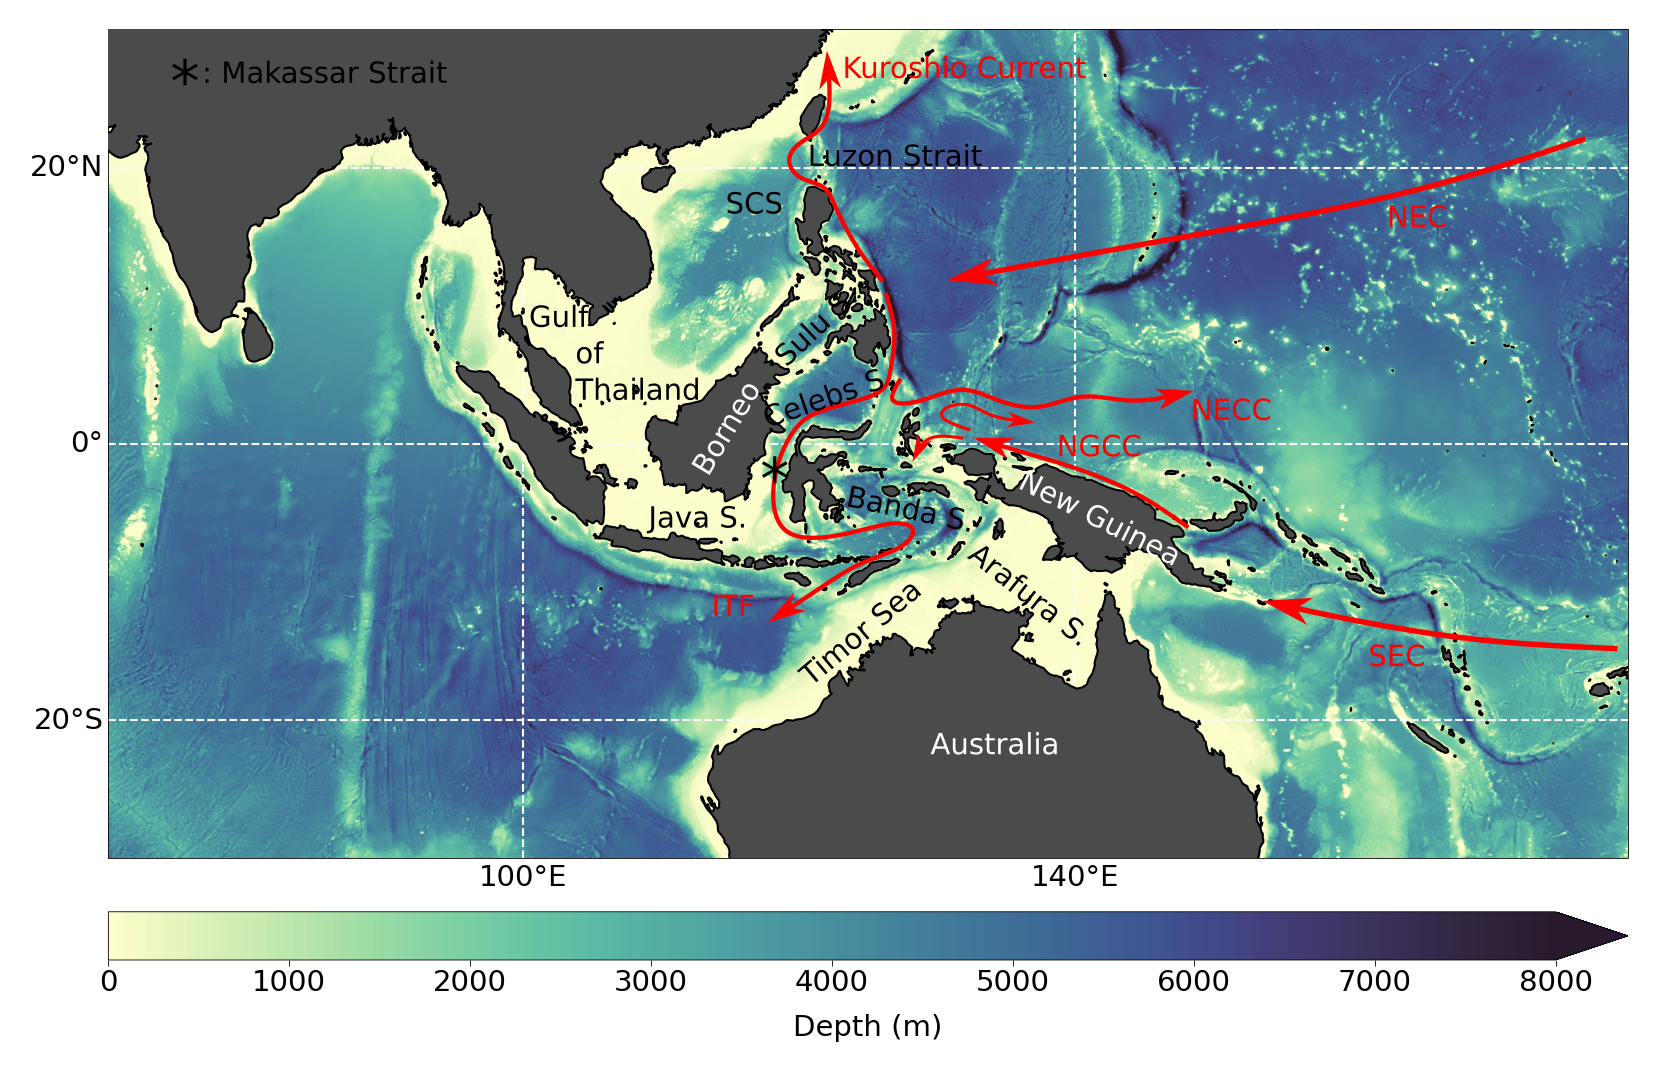

In [14]:
Image("FIGURE01/schematic.png")

Figure 1. Overview over study domain. Colorshading indicates depth. Marginal seas, islands, continents and schematic currents that are mentioned in the text are also marked. SCS: South China Sea, NEC: North Equatorial Current, SEC: South Equatorial Current, NECC: North Equatorial Counter Current.

### Figure 2

/gxfs_home/geomar/smomw233/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 6.79 s, sys: 119 ms, total: 6.91 s
Wall time: 7.05 s


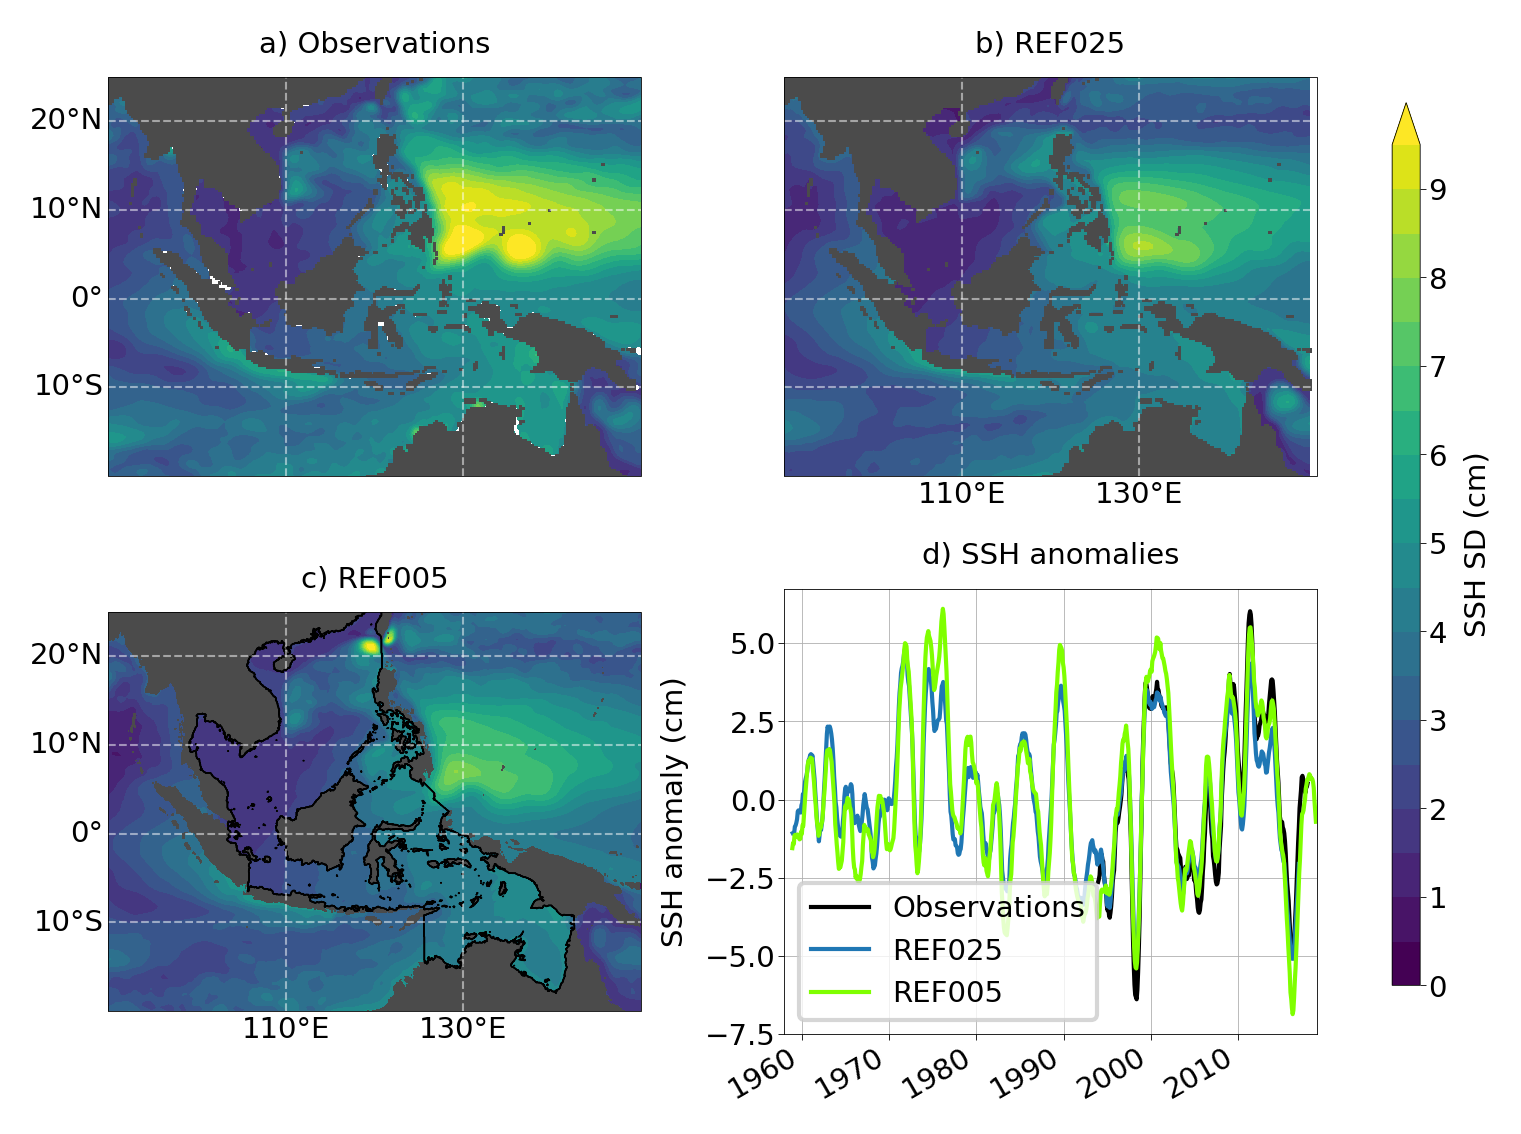

In [15]:
%%time
figure02()

Figure 2. SD of SSH from (a) observations and two hindcast experiments (b) REF025 and (c) REF005 over the period 1993 to 2016. d) SSH anomalies averaged over the region marked by black contours in panel c). The global mean trends over the integration period have been subtracted, and all data were smoothed with a 12-month running mean window.

### Figure 3

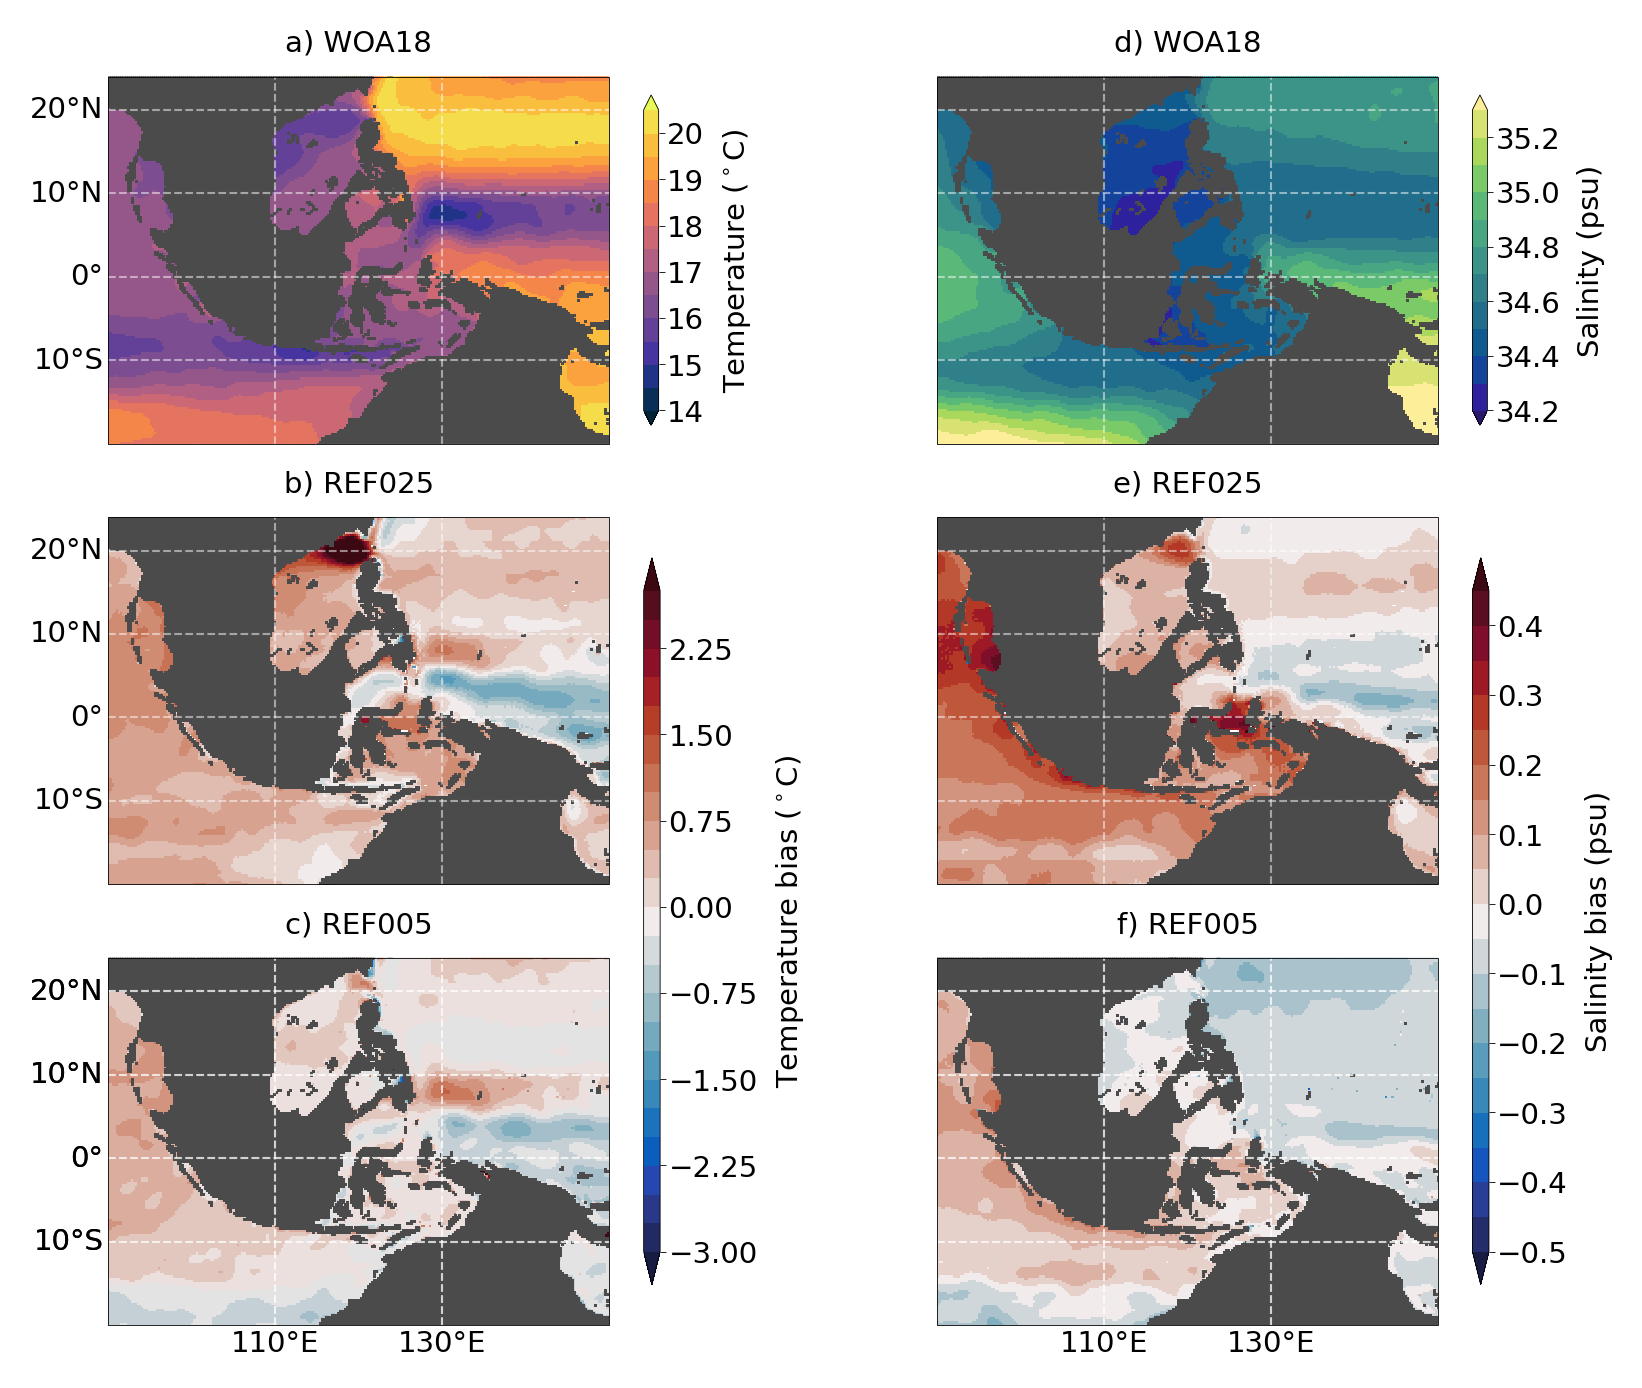

In [16]:
figure03()

Figure 3. Mean fields (1955–2017; upper row) and model biases (1958–2016; middle and bottom row) averaged over the upper 400 m for (a-c) temperature and (d-f) salinity. Note that data is only shown where the water depth exceeds 400 m.


### Figure 4

/gxfs_home/geomar/smomw233/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 1.21 s, sys: 49.9 ms, total: 1.26 s
Wall time: 1.28 s


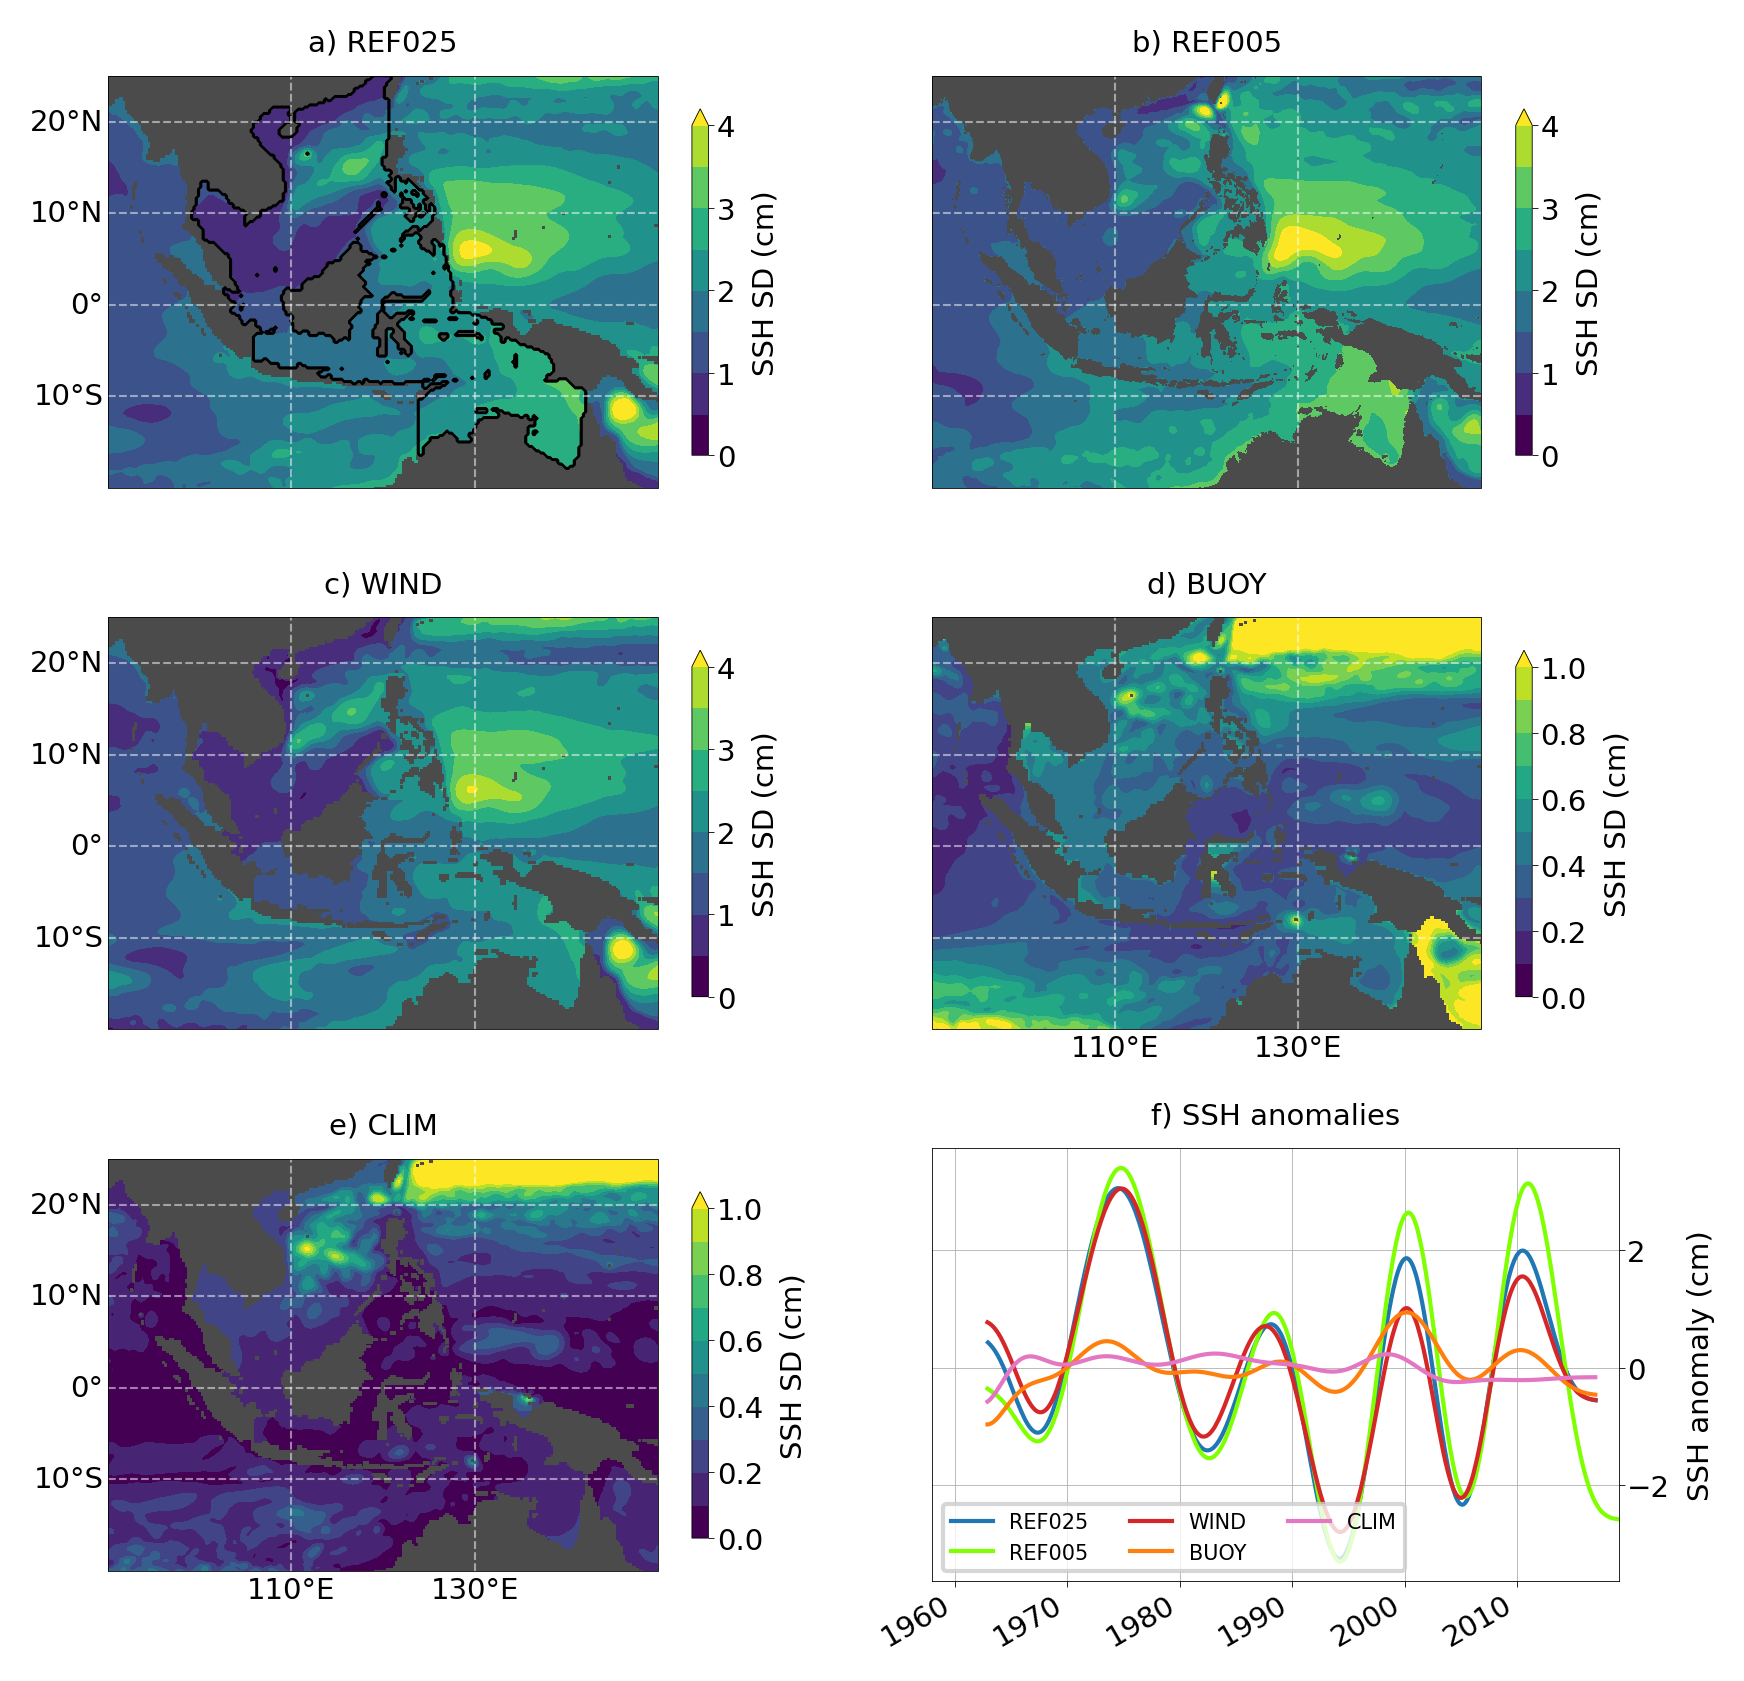

In [17]:
%%time
figure04()

Figure 4. SD of low-pass filtered SSH timeseries (8 years) from (a) REF025, (b) REF005, (c) WIND, (d) BUOY, (e) CLIM and (f) low-pass filtered SSH anomalies averaged over black contour lines shown in panel a). Note the different colorbars.


### Figure 5

CPU times: user 2.53 s, sys: 59.8 ms, total: 2.59 s
Wall time: 2.65 s


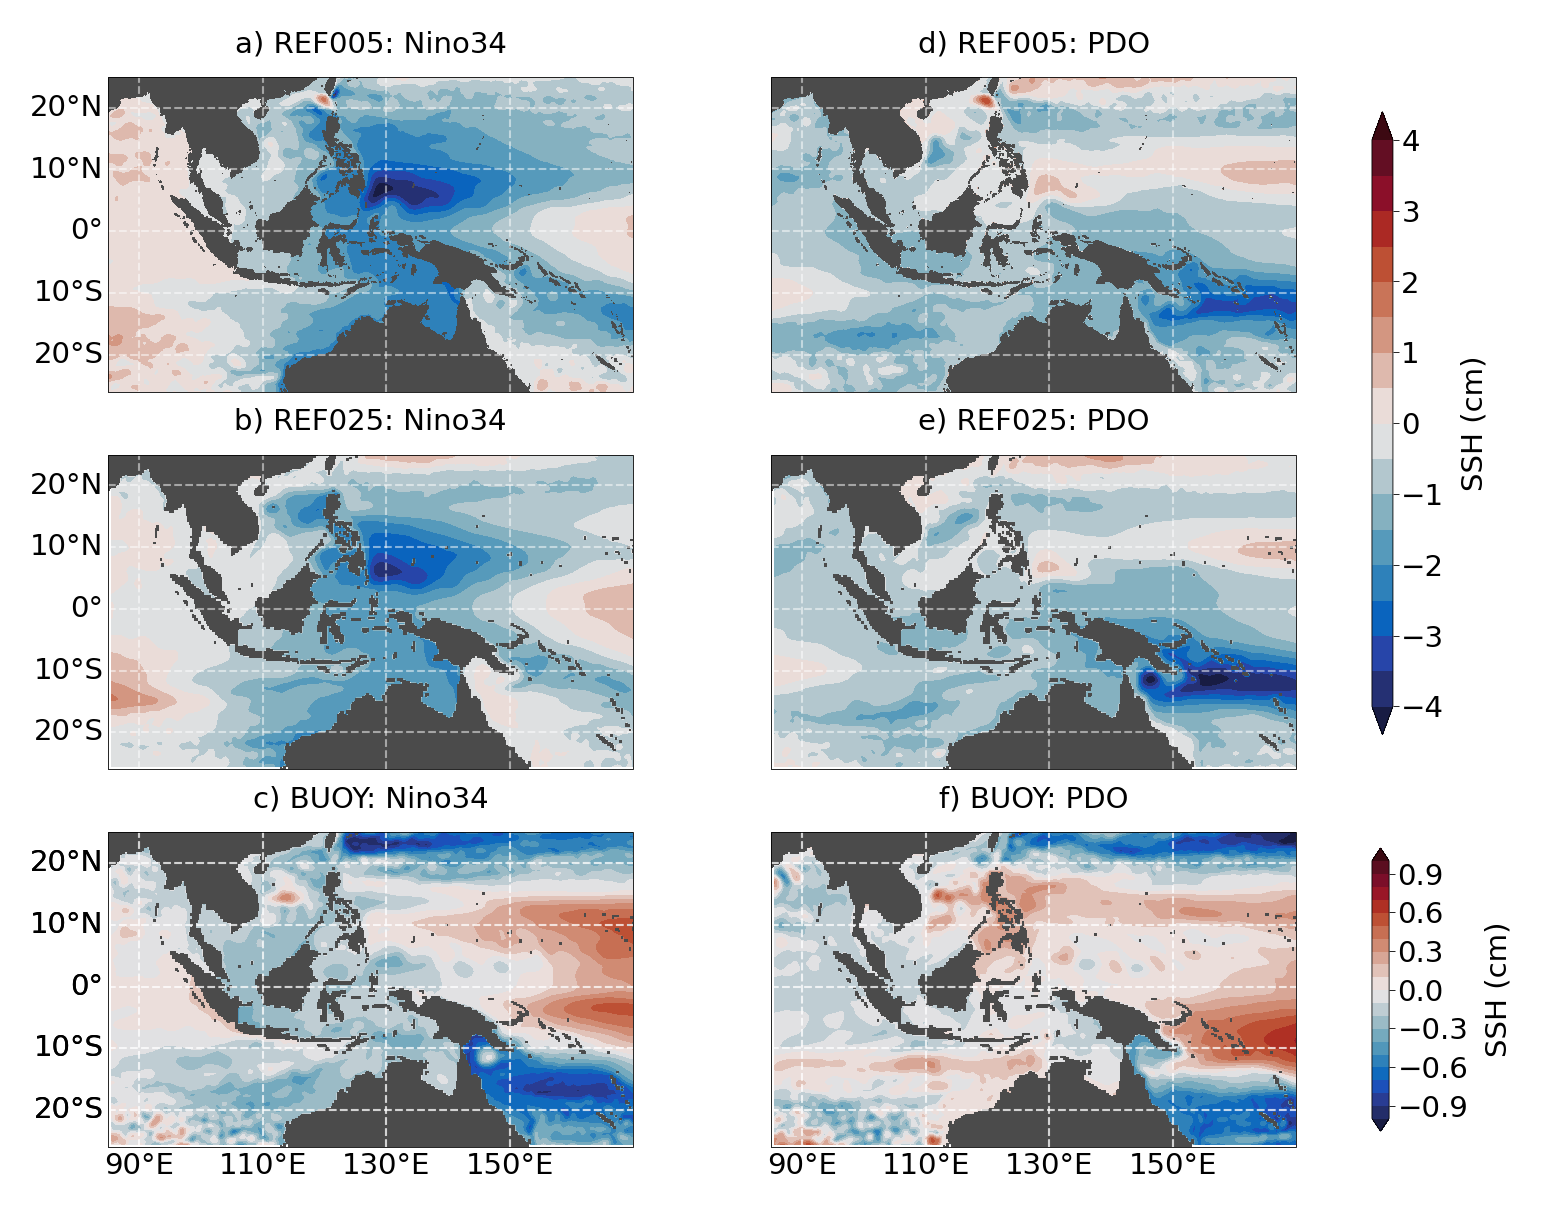

In [18]:
%%time
figure05()

Figure 5.  Linear regression of SSH with (a-c) Niño3.4 index and (d-f) PDO index for two hindcast (REF025, REF005) and buoyancy forcing experiments (BUOY). Climate indices are derived from its base model in case of REF005 and from REF025 for the other two experiments. All data has been filtered with an 8-year low-pass filter. Note the different colorbars.


### Figure 6

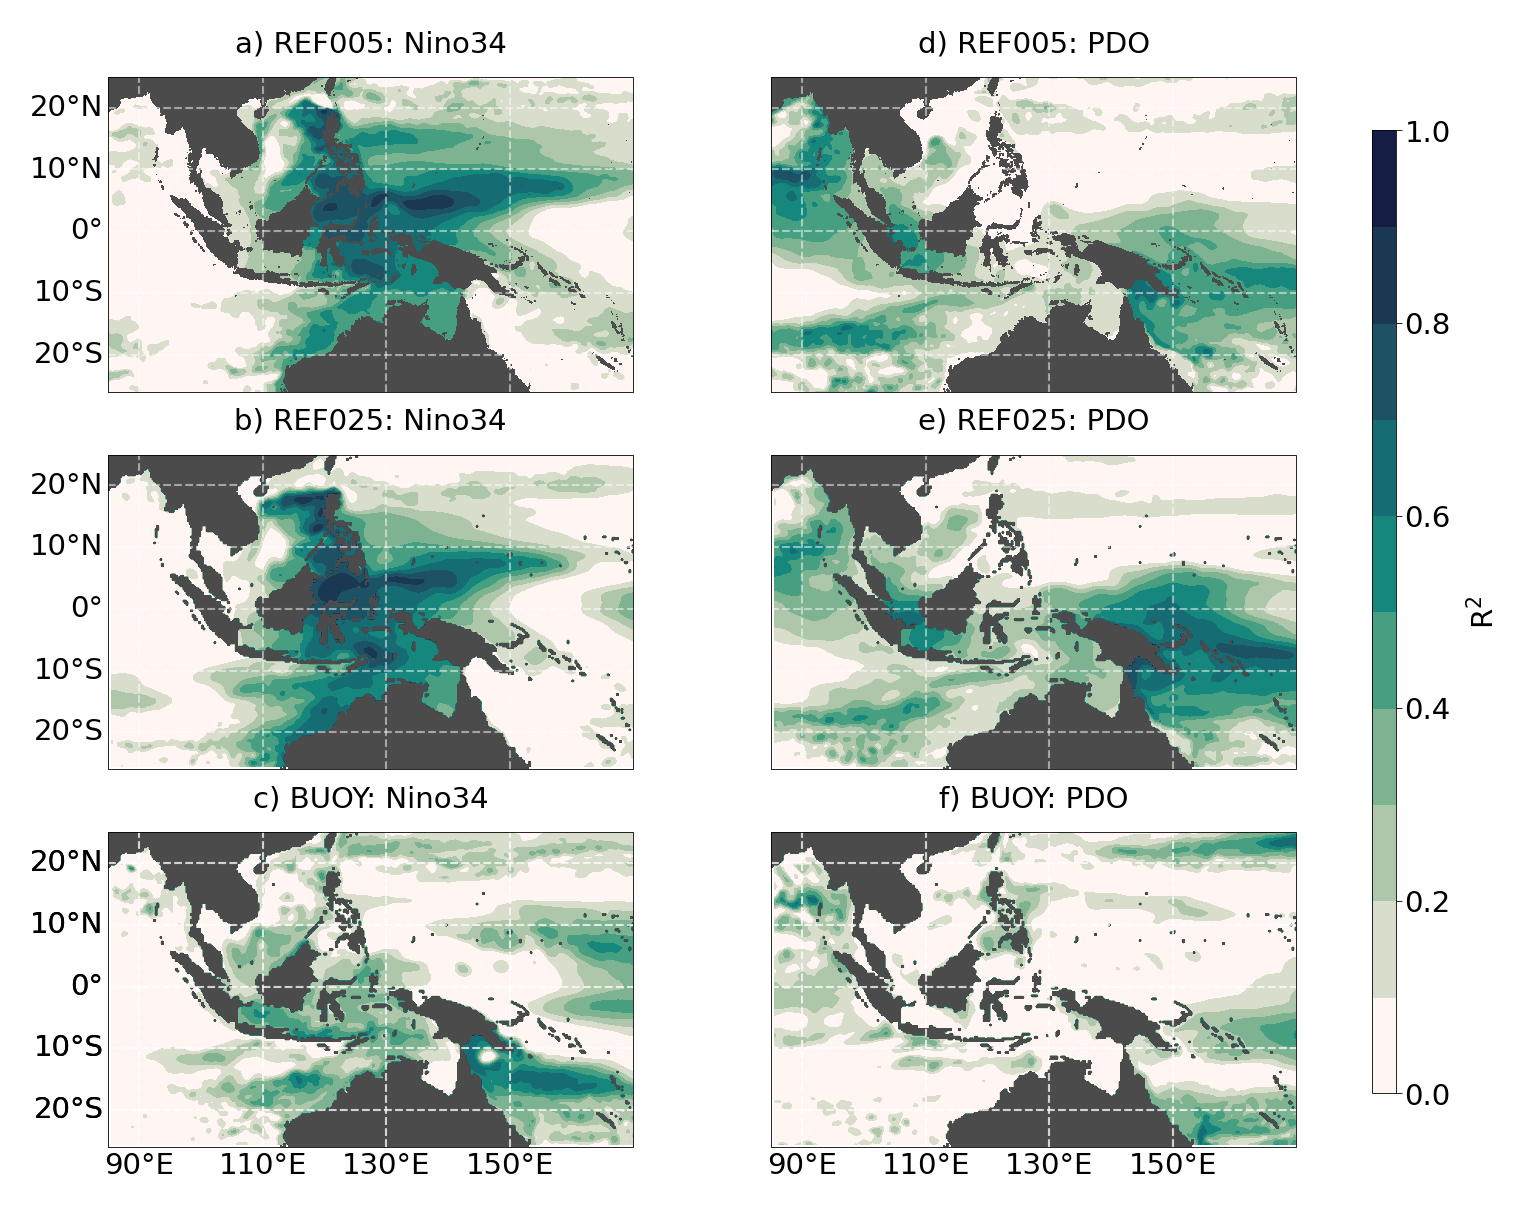

In [19]:
figure06()

Figure 6. Coefficient of determination for the linear regression of SSH with (a-c) Niño3.4 index and (d-f) PDO index for two hindcast (REF025, REF005) and buoyancy forcing experiments (BUOY). Climate indices are derived from its base model in case of REF005 and from REF025 for the other two experiments. All data has been filtered with an 8-year low-pass filter.


### Figure 7

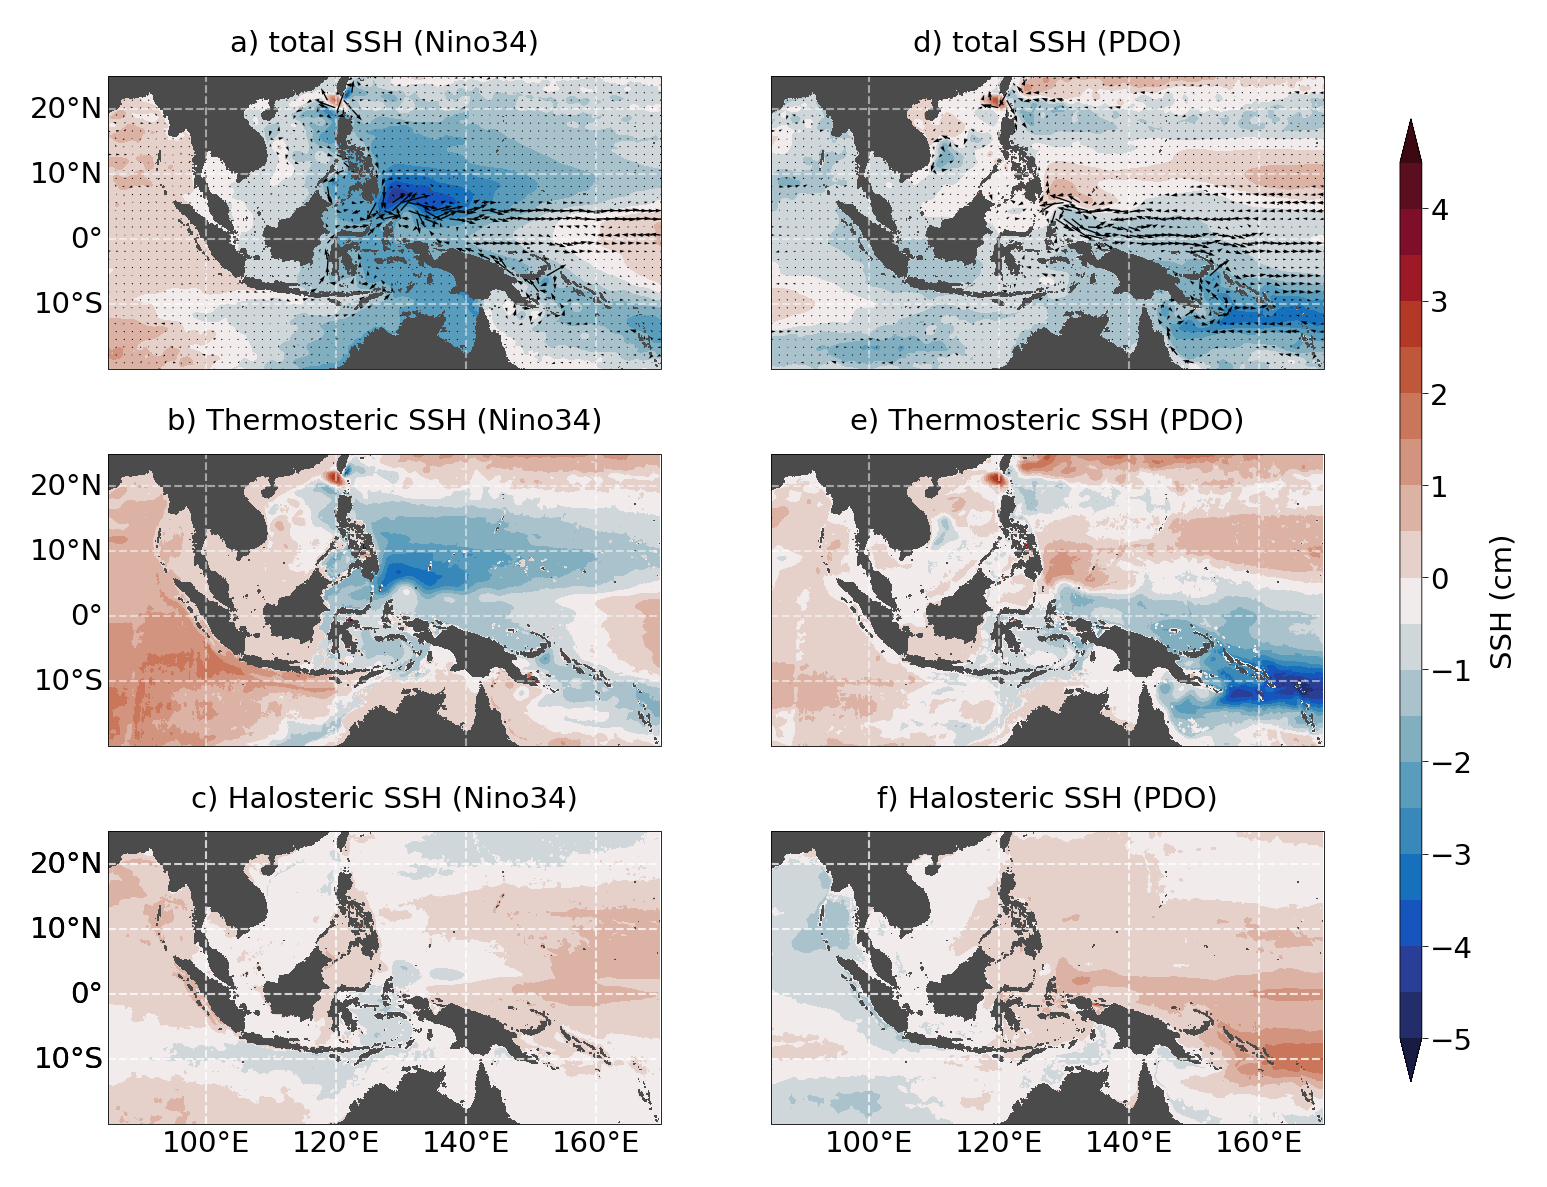

In [20]:
figure07()

Figure 7. Linear regression with (a-c) Niño3.4 and (d-f) PDO index of upper ocean currents (arrows; 0–150 m), total, thermosteric and
halosteric SSH. All data is taken from REF005 and were filtered with an 8-year low-pass filter. Note that the colour shading in panels a) and
b) is the same as in Fig. 5a, b)


### Figure 8

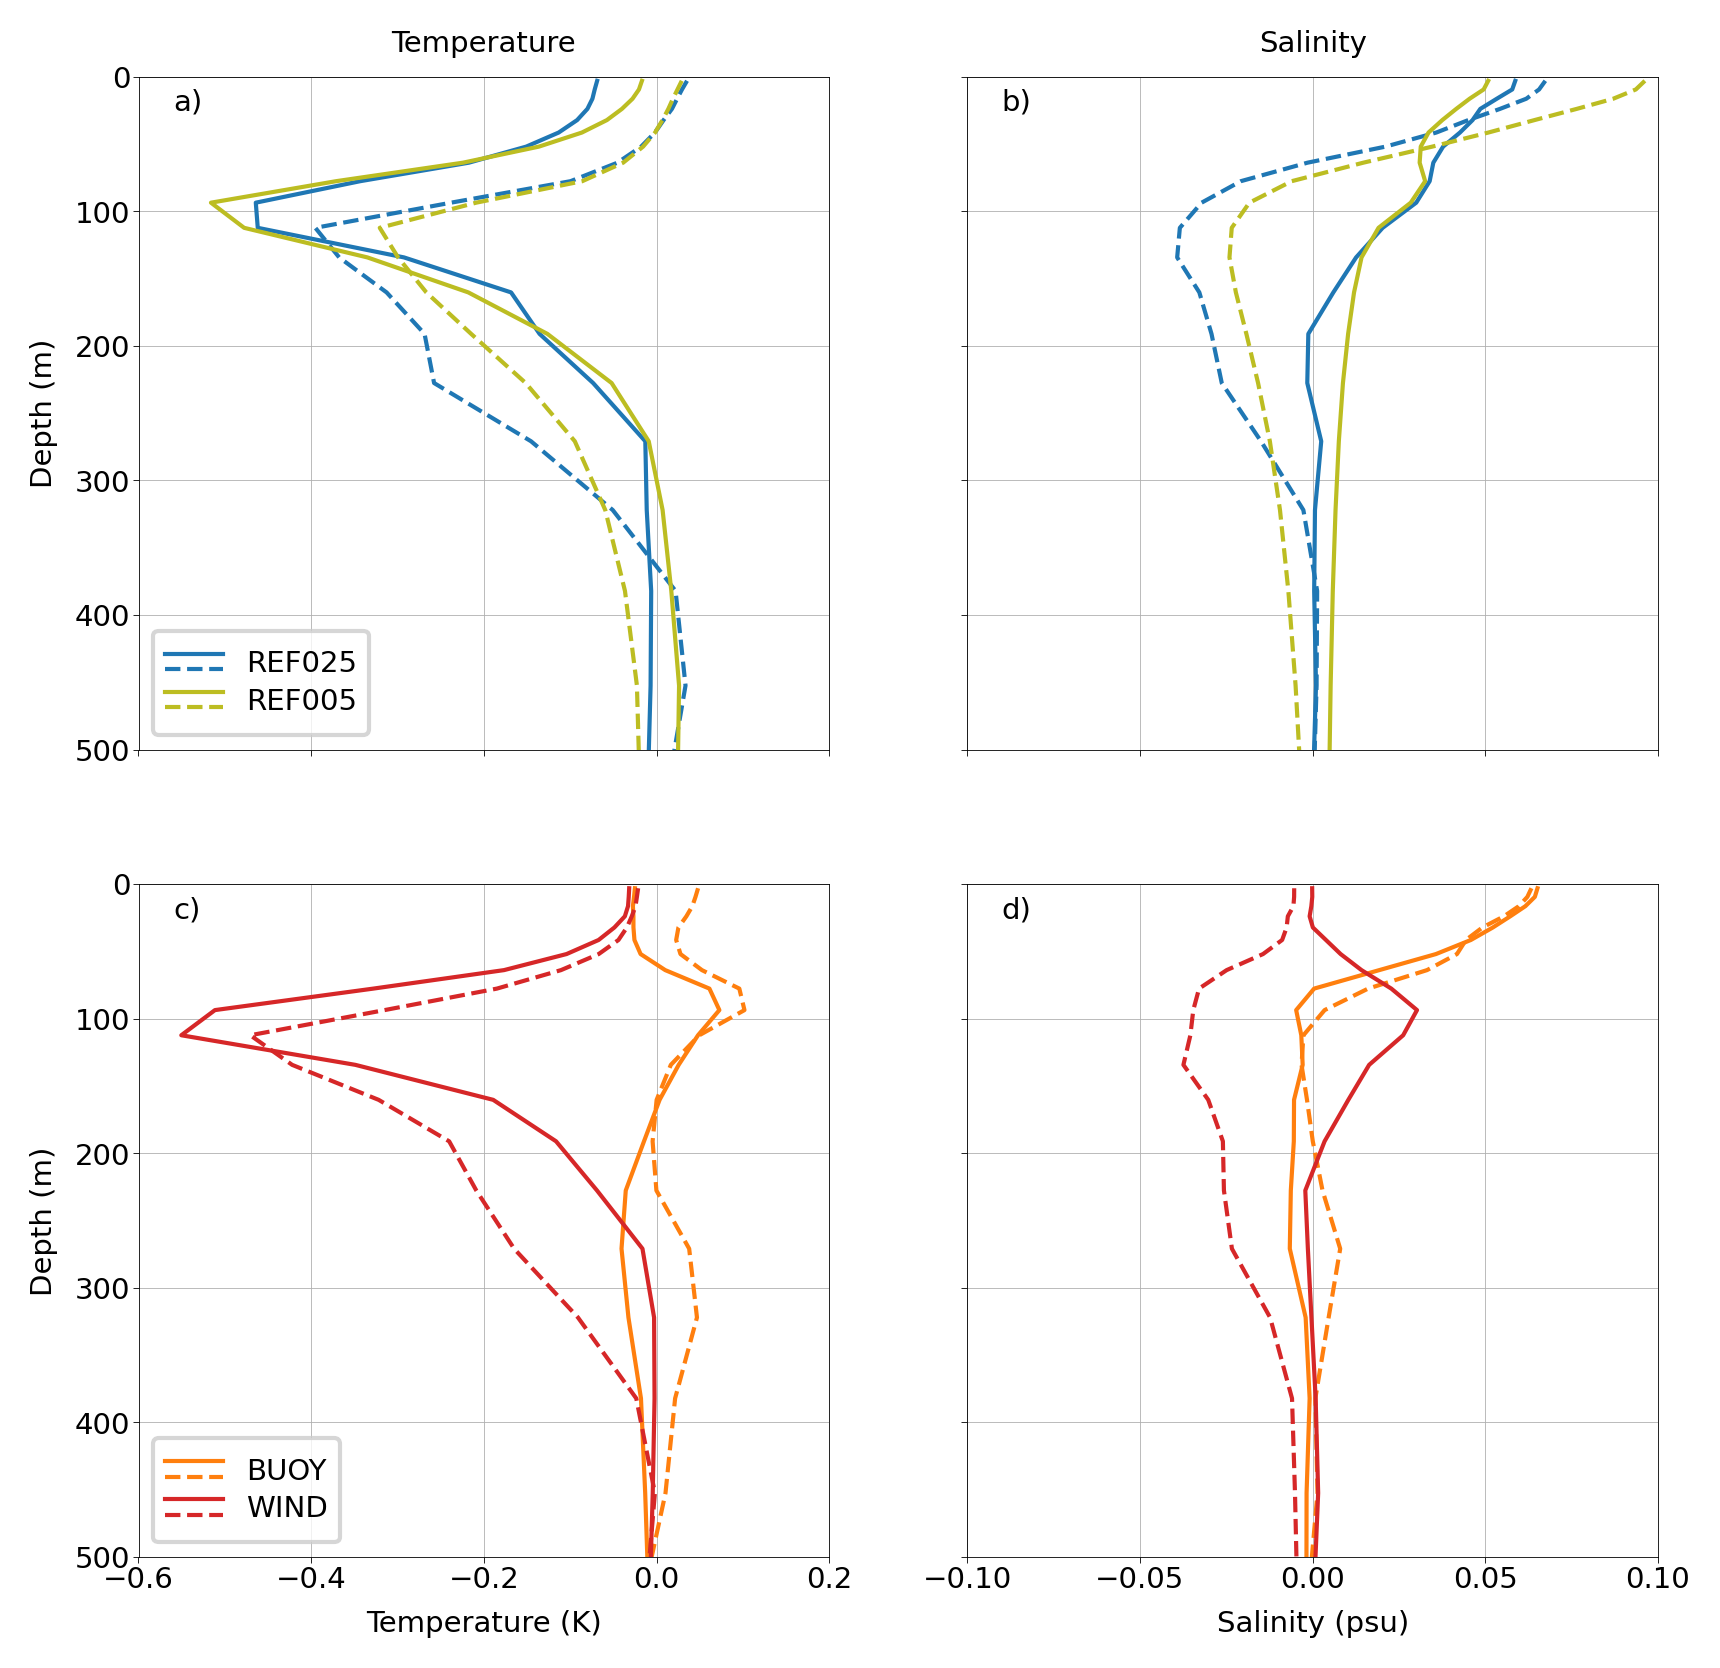

In [21]:
figure08()

Figure 8. Linear regression of temperature and salinity to Niño3.4 (solid) and PDO index (dashed) from (a, b) reference experiments and (c, d) sensitivity experiments. All data has been filtered with an 8-year low-pass filter.

### Figure A1

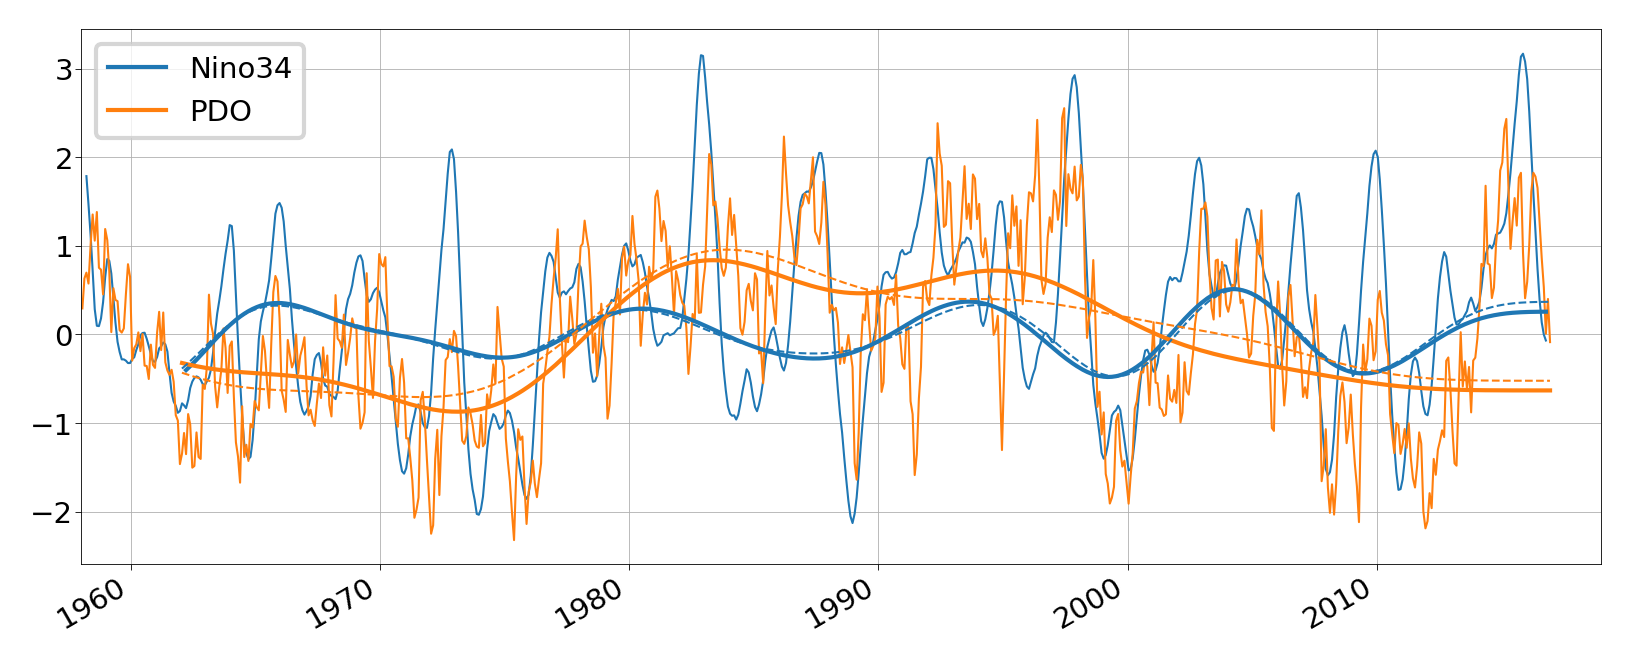

In [22]:
figurea1()

Figure A1. Niño3.4 index and PDO index, both calculated from REF025. Smoothed lines are band pass filtered with cutoff periods of 8
and 13 years (Niño3.4) and low-pass filtered with cutoff periods of 13 years (PDO). Dashed lines show observational estimates of the
PDO index (http://research.jisao.washington.edu/pdo/PDO.latest, last access: 08 Jun 2017; Mantua et al. 1997) and the Niño3.4 index
(https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.data, last access: 07 Jun 2017; Rayner et al. 2003)


### Figure A2

/gxfs_home/geomar/smomw233/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


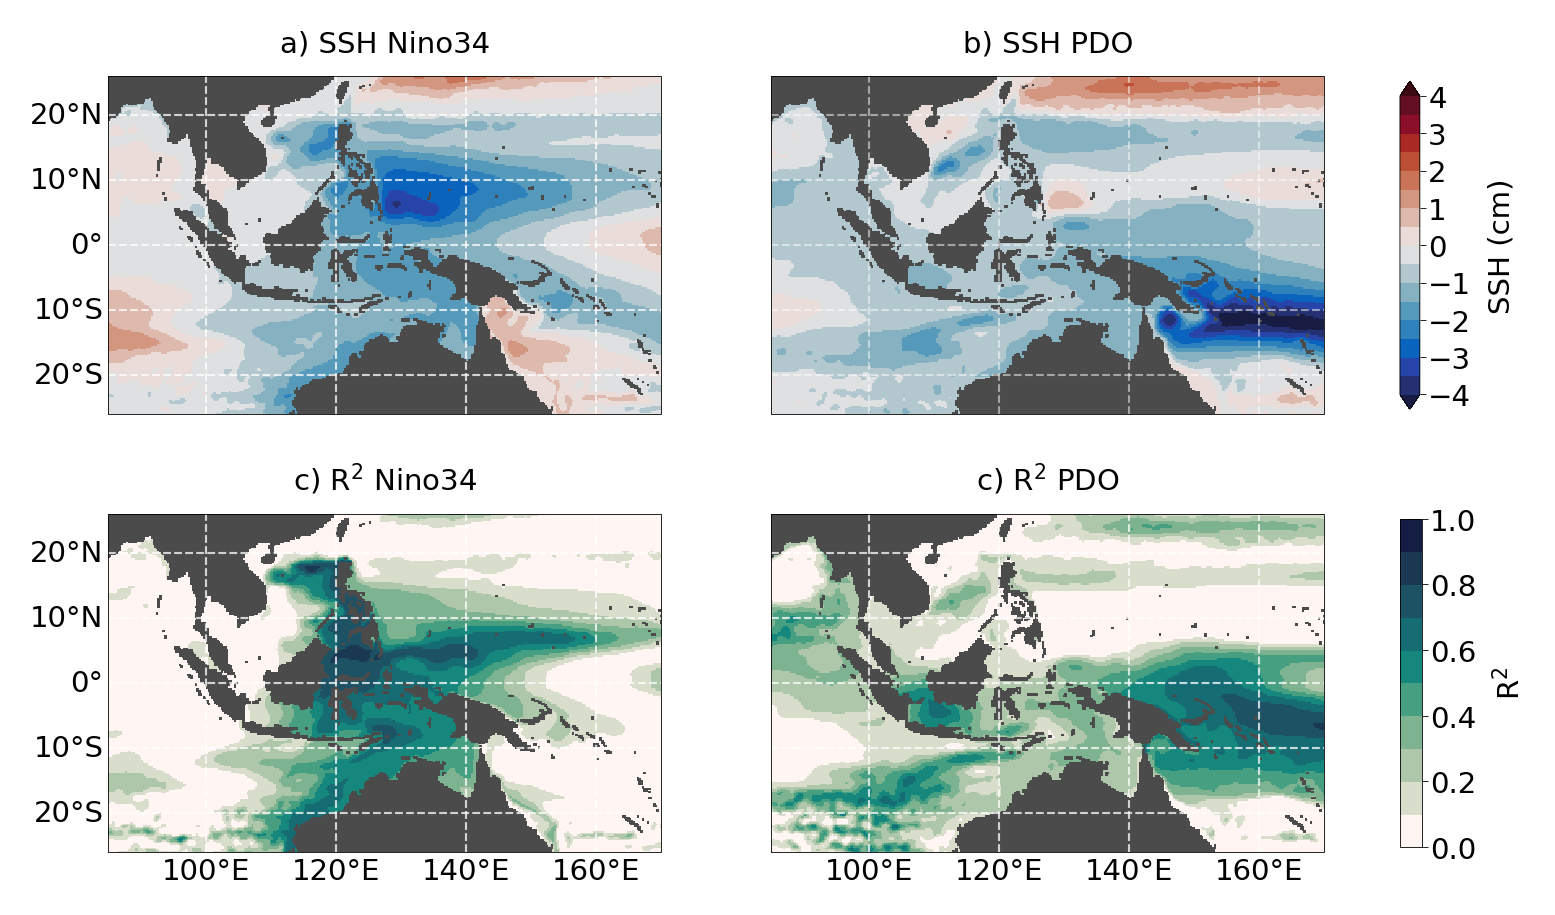

In [23]:
figurea2()

Figure A2.  Linear regression of SSH from WIND on (a) Niño3.4 and (b) PDO index and (c, d) respective coefficients of determination. Both climate indices are derived from REF025. All data were filtered with an 8-year low-pass filter.


In [24]:
!conda list

# packages in environment at /gxfs_home/geomar/smomw233/miniconda3/envs/py3_std:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
antlr-python-runtime      4.7.2           py37hc8dfbb8_1002    conda-forge
aospy                     0.3.1           py37h89c1867_1001    conda-forge
argon2-cffi               20.1.0           py37h5e8e339_2    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
basemap                   1.2.2        